# Evaluation de l'impact carbone de rouler en voiture

Data source: 
* main data: https://www.epa.gov/compliance-and-fuel-economy-data/data-cars-used-testing-fuel-economy
* CO2 eq pollution: https://www.data.gouv.fr/fr/datasets/base-carbone-complete-de-lademe-en-francais-v17-0/
* other one for CO2 eq pollution: https://legacy.winnipeg.ca/finance/findata/matmgt/documents/2012/682-2012/682-2012_appendix_h-wstp_south_end_plant_process_selection_report/appendix%207.pdf

<p>
Hypothèses des élémentes agravant les émissions de CO2
<ol>
<li>le poids</li>
<li>marque</li>
<li>Axel Ratio</li>
<li>la consommation</li>
<li>la motorisation</li>
<li>la transmmision</li>
<li>l'âge</li>
<li>la source d'énergie (le comburant ou l'électrique)</li>
</ol>
</p>
<p>

Points méthodologiques:
* dans cette étude nous allons procéder en tonne équivalent CO2

### Chargement des données

La première étape consiste toujours à charger les données. Avant le chargement, les données ont été converties du fichier Excel d'origine en CSV.

Libraries:
```bash
pip install pandas
pip install collections
pip install matplotlib
pip install seaborn
pip install sklearn
pip install openpyxl
```

In [1]:
# download libraries
# --

In [2]:
# import them
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import os
from scipy.stats import shapiro, pearsonr, spearmanr, kendalltau
import math
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm


In [3]:
#load the data
data_folder = "./data/"

list_of_files = [pd.read_excel(f'{data_folder}{f}') for f in os.listdir(data_folder) if f.endswith('.xlsx')]
for i in range(len(list_of_files[0].columns)):
    i_column = []
    for df in list_of_files:
        i_column.append(df.columns[i])
    #print all unique values in the list
    if len(set(i_column)) > 1:
        print(f"{i_column} has multiple values")
        print("\n")
    

In [4]:
# merge the dfs
df = pd.concat(list_of_files, axis=0, ignore_index=True)

## Styles pour le _notebook_

In [5]:
#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
#np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
pd.options.display.float_format = '{:,.3f}'.format

# plot default size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

In [6]:
# always print full output
pd.set_option('display.max_rows', 500)

## Visualiser les données

In [7]:
df.shape

(39182, 67)

In [8]:
columns = df.columns
print ('columns:\n{0}'.format('\n'.join(df.columns)))
df.head(5)

columns:
Model Year
Vehicle Manufacturer Name
Veh Mfr Code
Represented Test Veh Make
Represented Test Veh Model
Test Vehicle ID
Test Veh Configuration #
Test Veh Displacement (L)
Actual Tested Testgroup
Vehicle Type
Rated Horsepower
# of Cylinders and Rotors
Engine Code
Tested Transmission Type Code
Tested Transmission Type
# of Gears
Transmission Lockup?
Drive System Code
Drive System Description
Transmission Overdrive Code
Transmission Overdrive Desc
Equivalent Test Weight (lbs.)
Axle Ratio
N/V Ratio
Shift Indicator Light Use Cd
Shift Indicator Light Use Desc
Test Number
Test Originator
Analytically Derived FE?
ADFE Test Number
ADFE Total Road Load HP
ADFE Equiv. Test Weight (lbs.)
ADFE N/V Ratio
Test Procedure Cd
Test Procedure Description
Test Fuel Type Cd
Test Fuel Type Description
Test Category
THC (g/mi)
CO (g/mi)
CO2 (g/mi)
NOx (g/mi)
PM (g/mi)
CH4 (g/mi)
N2O (g/mi)
RND_ADJ_FE
FE_UNIT
FE Bag 1
FE Bag 2
FE Bag 3
FE Bag 4
DT-Inertia Work Ratio Rating
DT-Absolute Speed Change Ratg

Model Year Vehicle Manufacturer Name Veh Mfr Code  \
0        2017              aston martin          ASX   
1        2017              aston martin          ASX   
2        2017              aston martin          ASX   
3        2017              aston martin          ASX   
4        2017              aston martin          ASX   

  Represented Test Veh Make Represented Test Veh Model Test Vehicle ID  \
0              Aston Martin                       DB11       500TT5148   
1              Aston Martin                       DB11       500TT5148   
2              Aston Martin                   Rapide S       410TT4202   
3              Aston Martin                   Rapide S       410TT4202   
4              Aston Martin              V12 Vantage S       288TT2087   

   Test Veh Configuration #  Test Veh Displacement (L)  \
0                         0                      5.200   
1                         0                      5.200   
2                         0                      6.000   
3                         0                      6.000   
4                         0                      6.000   

  Actual Tested Testgroup Vehicle Type  ...  Set Coef A (lbf)  \
0            HASXV05.2AM5          Car  ...             6.810   
1            HASXV05.2AM5          Car  ...             6.810   
2            FASXV06.0VHB          Car  ...             1.093   
3            FASXV06.0VHB          Car  ...             1.093   
4            FASXV06.0VHB          Car  ...            17.420   

   Set Coef B (lbf/mph) Set Coef C (lbf/mph**2) Aftertreatment Device Cd  \
0                 0.081                   0.025                      TWC   
1                 0.081                   0.025                      TWC   
2                 2.198                   0.028                      TWC   
3                 2.198                   0.028                      TWC   
4                 0.406                   0.019                      TWC   

  Aftertreatment Device Desc  Police - Emergency Vehicle? Averaging Group ID  \
0         Three-way catalyst                            N                NaN   
1         Three-way catalyst                            N                NaN   
2         Three-way catalyst                            N                NaN   
3         Three-way catalyst                            N                NaN   
4         Three-way catalyst                            N                NaN   

  Averaging Weighting Factor Averaging Method Cd  Averging Method Desc  
0                        NaN                   N          No averaging  
1                        NaN                   N          No averaging  
2                        NaN                   N          No averaging  
3                        NaN                   N          No averaging  
4                        NaN                   N          No averaging  

[5 rows x 67 columns]

In [9]:
# obtaining data description
df.describe()

Model Year  Test Veh Configuration #  Test Veh Displacement (L)  \
count  39,182.000                39,182.000                 39,182.000   
mean    2,020.791                     1.051                      3.541   
std         2.523                     1.702                      8.544   
min     2,017.000                     0.000                      0.001   
25%     2,019.000                     0.000                      2.000   
50%     2,021.000                     0.000                      2.500   
75%     2,023.000                     1.000                      3.500   
max     2,025.000                    19.000                     99.999   

       Rated Horsepower  # of Cylinders and Rotors  # of Gears  \
count        39,182.000                 36,611.000  39,182.000   
mean            306.834                      5.382       6.315   
std             158.673                      1.799       2.896   
min               1.000                      2.000       1.000   
25%             185.000                      4.000       6.000   
50%             280.000                      4.000       7.000   
75%             375.000                      6.000       8.000   
max           1,839.000                     16.000      10.000   

       Transmission Overdrive Code  Equivalent Test Weight (lbs.)  Axle Ratio  \
count                   39,182.000                     39,182.000  39,182.000   
mean                         1.934                      4,460.993       3.675   
std                          0.248                        884.299       1.265   
min                          1.000                      2,375.000       0.000   
25%                          2.000                      3,875.000       3.150   
50%                          2.000                      4,250.000       3.420   
75%                          2.000                      5,000.000       3.820   
max                          2.000                      9,000.000       9.990   

       N/V Ratio  ...  DT-Inertia Work Ratio Rating  \
count 39,182.000  ...                    34,615.000   
mean      35.954  ...                         3.418   
std       66.104  ...                        16.894   
min        0.000  ...                       -26.876   
25%       24.000  ...                        -0.710   
50%       26.400  ...                         0.479   
75%       30.900  ...                         2.102   
max      999.900  ...                        99.990   

       DT-Absolute Speed Change Ratg  DT-Energy Economy Rating  \
count                     34,615.000                34,615.000   
mean                           3.291                     2.806   
std                           16.787                    17.135   
min                          -50.263                   -17.818   
25%                           -0.552                    -0.597   
50%                            0.308                    -0.141   
75%                            1.481                     0.232   
max                           99.990                    99.990   

       Target Coef A (lbf)  Target Coef B (lbf/mph)  \
count           39,182.000               39,182.000   
mean                39.626                    0.235   
std                 12.183                    0.316   
min                 15.431                   -0.821   
25%                 30.720                    0.054   
50%                 38.300                    0.246   
75%                 46.950                    0.419   
max                 93.000                    2.408   

       Target Coef C (lbf/mph**2)  Set Coef A (lbf)  Set Coef B (lbf/mph)  \
count                  39,182.000        39,182.000            39,182.000   
mean                        0.024            10.359                 0.112   
std                         0.007            11.769                 0.309   
min                         0.009           -99.900                -1.975   
25%                         0.018          

On observe une répartition relativement bonne, nous l'approfondirons plus tard

On observe aussi certaines colonnes avec peu de valeur non-nulles (ligne _count_ colonne _Averaging Weighting Factor_).

On observe aussi certains valeurs suprenante comme le max pour les colonnes commencant par DT (99.990) Axel Ratio etc.. Ces valeures s'expliquent par la présence de calcules et de ratios.
Pour DT le ratio est: 
$$
\text{DT-Inertia Work Ratio} = \frac{\text{Inertia} \times \text{Work Done}}{\text{Deceleration Torque (DT)}}
$$

 


In [10]:
# Math representation of the input and output variables
# shows how many uniques values in each column

for column in columns:
    print ('{0}\t\t\t\t{1}'.format(column, len(set(df[column]))))

Model Year				9
Vehicle Manufacturer Name				51
Veh Mfr Code				50
Represented Test Veh Make				89
Represented Test Veh Model				2163
Test Vehicle ID				3984
Test Veh Configuration #				20
Test Veh Displacement (L)				103
Actual Tested Testgroup				2218
Vehicle Type				3
Rated Horsepower				431
# of Cylinders and Rotors				2580
Engine Code				1737
Tested Transmission Type Code				8
Tested Transmission Type				8
# of Gears				9
Transmission Lockup?				2
Drive System Code				5
Drive System Description				5
Transmission Overdrive Code				2
Transmission Overdrive Desc				2
Equivalent Test Weight (lbs.)				26
Axle Ratio				252
N/V Ratio				457
Shift Indicator Light Use Cd				4
Shift Indicator Light Use Desc				4
Test Number				20181
Test Originator				2
Analytically Derived FE?				2
ADFE Test Number				1426
ADFE Total Road Load HP				35345
ADFE Equiv. Test Weight (lbs.)				35206
ADFE N/V Ratio				35339
Test Procedure Cd				16
Test Procedure Description				16
Test Fuel Type Cd				16
Test Fue

## Nettoyage des données

In [11]:
df_clean = df.copy()

### Valeures nulles
On calcule les ratios de valeurs nulles avec la formule: 
$$
\text{Ratio} = \frac{\text{Nombre de valeures manquantes}}{\text{Taille de l'échantillon}}
$$


ADFE Test Number missing rate: 0.8979633505180951
ADFE Total Road Load HP missing rate: 0.8979633505180951
ADFE Equiv. Test Weight (lbs.) missing rate: 0.8979633505180951
ADFE N/V Ratio missing rate: 0.8979633505180951
PM (g/mi) missing rate: 0.840028584554132
N2O (g/mi) missing rate: 0.5064060027563677
FE Bag 1 missing rate: 0.5354754734316778
FE Bag 2 missing rate: 0.5354754734316778
FE Bag 3 missing rate: 0.6168393650145475
FE Bag 4 missing rate: 0.9520187841355725
Averaging Group ID missing rate: 0.9712112704813435
Averaging Weighting Factor missing rate: 0.9712112704813435


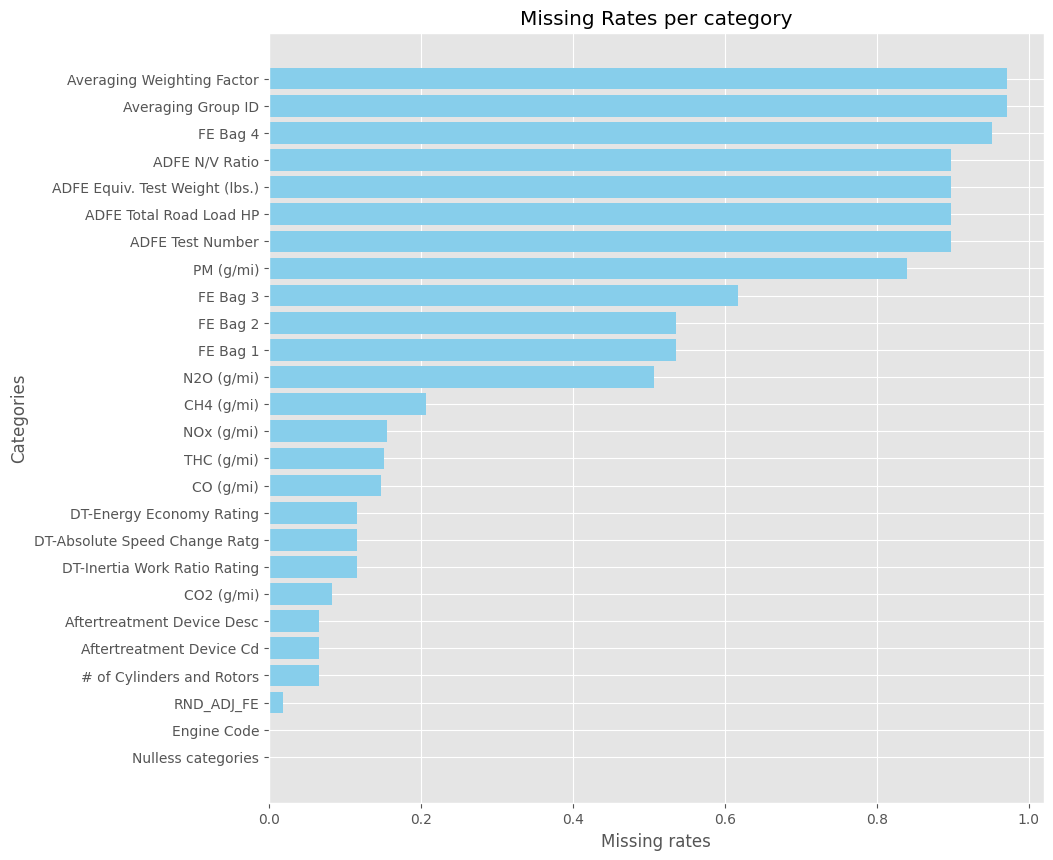

In [12]:
# count number of null values each column

missing_rates = []
# for every columns with more than 50% of missing values, print the column name
null_columns = []
for column in columns:
    missing_rate = df_clean[column].isnull().sum()/df_clean.shape[0]
    missing_rates.append([column, missing_rate])
    if missing_rate > 0.5:
        print (f"{column} missing rate: {missing_rate}")
        null_columns.append(column)

#bar plot of missing rate
missing_rates = sorted([x for x in missing_rates if x[1] > 0], key=lambda x: x[1])
missing_rates.insert(0,["Nulless categories", 0])
plt.figure(figsize=(10, 10))
plt.barh([x[0] for x in missing_rates], [x[1] for x in missing_rates], color='skyblue')
plt.xlabel('Missing rates')
plt.ylabel('Categories')
plt.title('Missing Rates per category')
plt.show()
        

#### Explication pour  les valeures nulles de _Averaging factor_

In [13]:
df_clean.describe()

Model Year  Test Veh Configuration #  Test Veh Displacement (L)  \
count  39,182.000                39,182.000                 39,182.000   
mean    2,020.791                     1.051                      3.541   
std         2.523                     1.702                      8.544   
min     2,017.000                     0.000                      0.001   
25%     2,019.000                     0.000                      2.000   
50%     2,021.000                     0.000                      2.500   
75%     2,023.000                     1.000                      3.500   
max     2,025.000                    19.000                     99.999   

       Rated Horsepower  # of Cylinders and Rotors  # of Gears  \
count        39,182.000                 36,611.000  39,182.000   
mean            306.834                      5.382       6.315   
std             158.673                      1.799       2.896   
min               1.000                      2.000       1.000   
25%             185.000                      4.000       6.000   
50%             280.000                      4.000       7.000   
75%             375.000                      6.000       8.000   
max           1,839.000                     16.000      10.000   

       Transmission Overdrive Code  Equivalent Test Weight (lbs.)  Axle Ratio  \
count                   39,182.000                     39,182.000  39,182.000   
mean                         1.934                      4,460.993       3.675   
std                          0.248                        884.299       1.265   
min                          1.000                      2,375.000       0.000   
25%                          2.000                      3,875.000       3.150   
50%                          2.000                      4,250.000       3.420   
75%                          2.000                      5,000.000       3.820   
max                          2.000                      9,000.000       9.990   

       N/V Ratio  ...  DT-Inertia Work Ratio Rating  \
count 39,182.000  ...                    34,615.000   
mean      35.954  ...                         3.418   
std       66.104  ...                        16.894   
min        0.000  ...                       -26.876   
25%       24.000  ...                        -0.710   
50%       26.400  ...                         0.479   
75%       30.900  ...                         2.102   
max      999.900  ...                        99.990   

       DT-Absolute Speed Change Ratg  DT-Energy Economy Rating  \
count                     34,615.000                34,615.000   
mean                           3.291                     2.806   
std                           16.787                    17.135   
min                          -50.263                   -17.818   
25%                           -0.552                    -0.597   
50%                            0.308                    -0.141   
75%                            1.481                     0.232   
max                           99.990                    99.990   

       Target Coef A (lbf)  Target Coef B (lbf/mph)  \
count           39,182.000               39,182.000   
mean                39.626                    0.235   
std                 12.183                    0.316   
min                 15.431                   -0.821   
25%                 30.720                    0.054   
50%                 38.300                    0.246   
75%                 46.950                    0.419   
max                 93.000                    2.408   

       Target Coef C (lbf/mph**2)  Set Coef A (lbf)  Set Coef B (lbf/mph)  \
count                  39,182.000        39,182.000            39,182.000   
mean                        0.024            10.359                 0.112   
std                         0.007            11.769                 0.309   
min                         0.009           -99.900                -1.975   
25%                         0.018          

In [14]:
# Pour étudier les valeurs nulles, on isole un dataframe en ayant aucune et un en ayant. On comparera alors leurs valeurs.
df_avg = df_clean.copy()
df_avg = df_avg.dropna(subset=["Averaging Weighting Factor"])
print("sans valeures nulles")
print(f"taille: {df_avg.shape[0]}")
print(" \navec valeures nulles")
df_comparision = df_clean.copy()
print(f"taille: {df_comparision.shape[0]}")
df_comparision["Averaging Weighting type"] = df_comparision["Averaging Weighting Factor"].apply(lambda x: "Weighted" if math.isnan(x)   else "Unweighted")


sans valeures nulles
taille: 1128
 
avec valeures nulles
taille: 39182


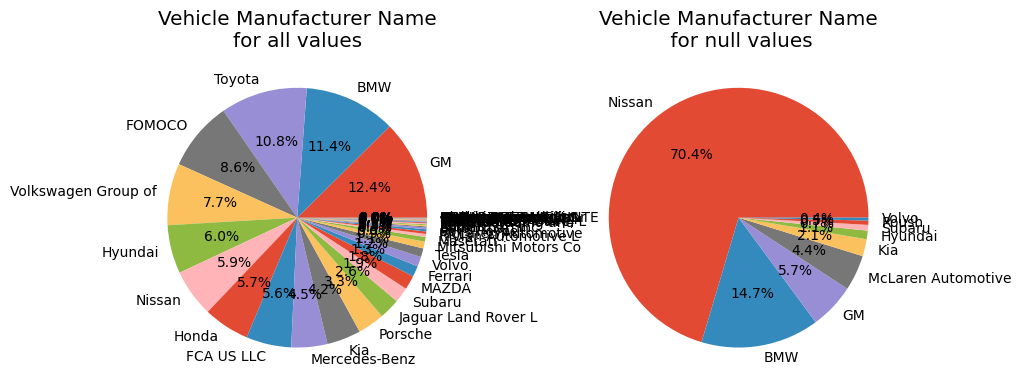

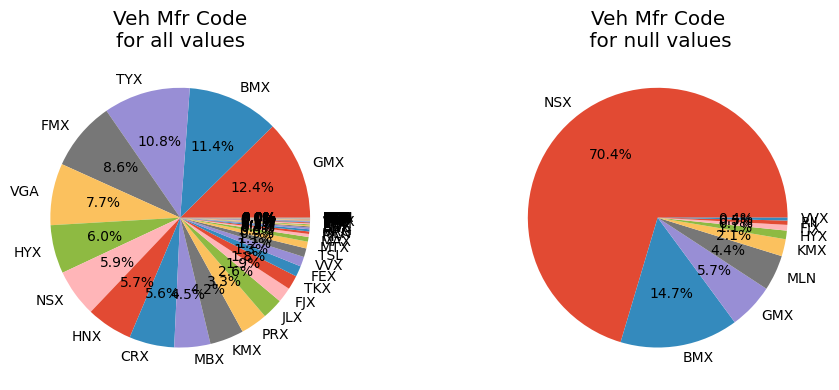

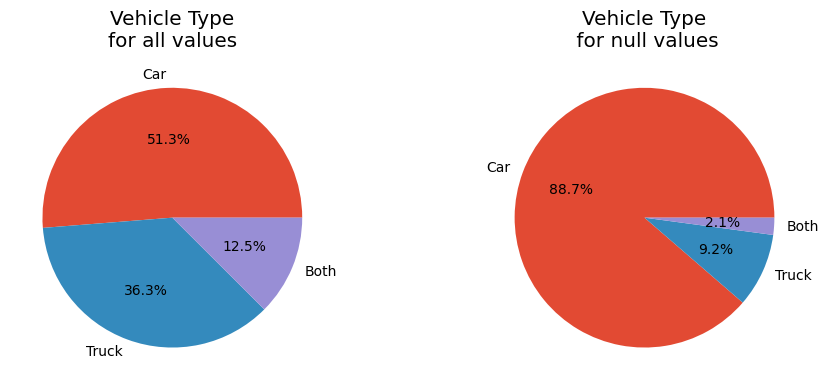

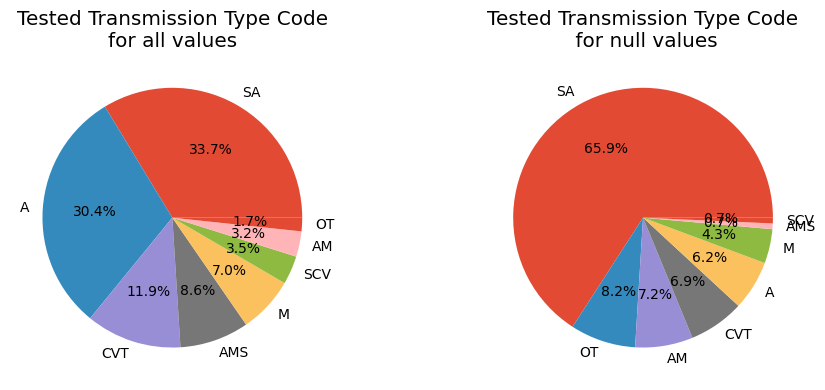

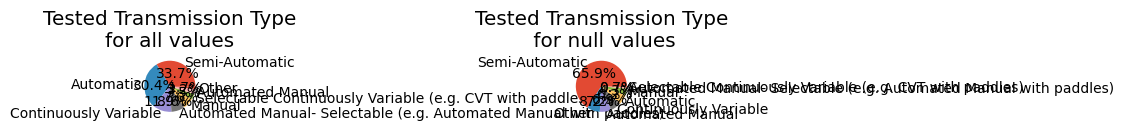

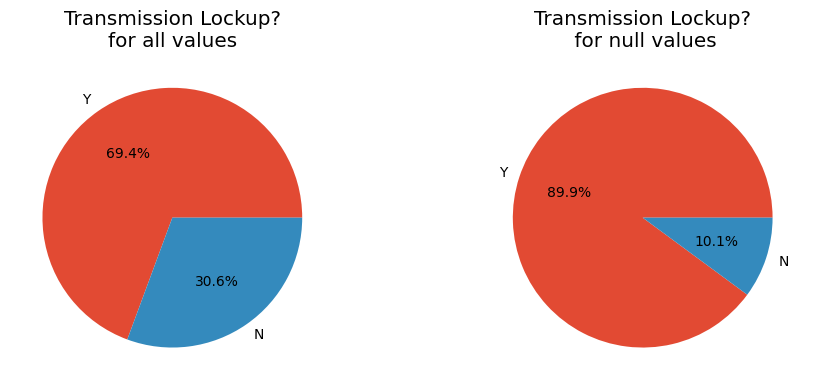

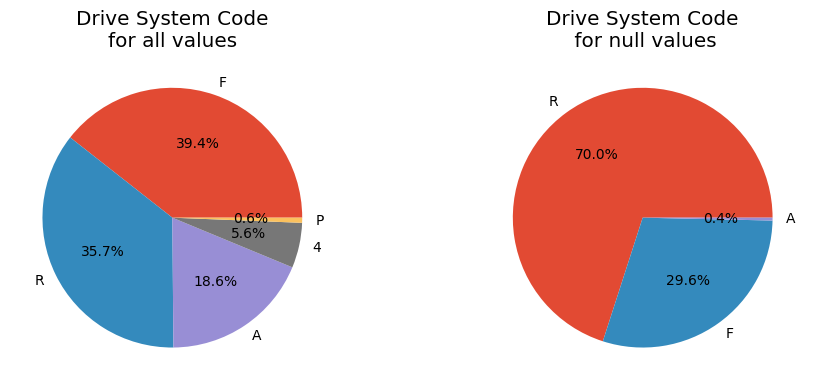

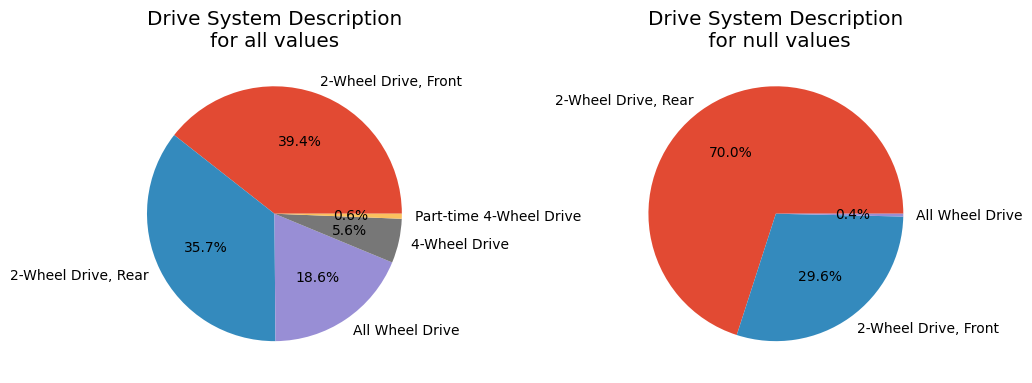

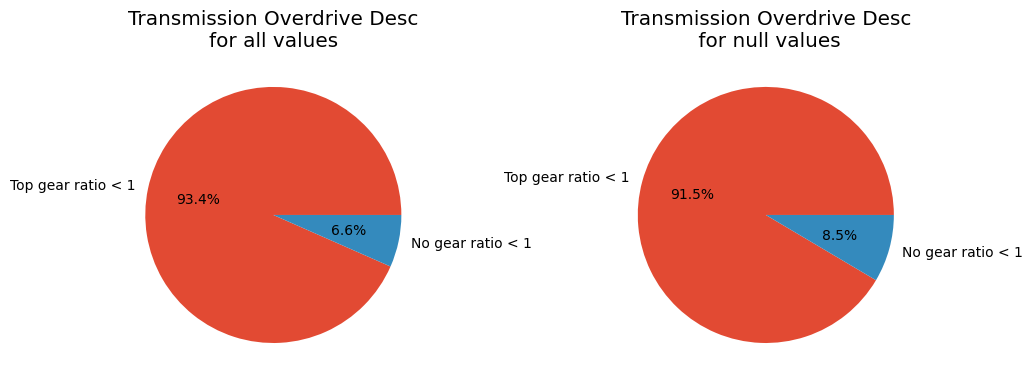

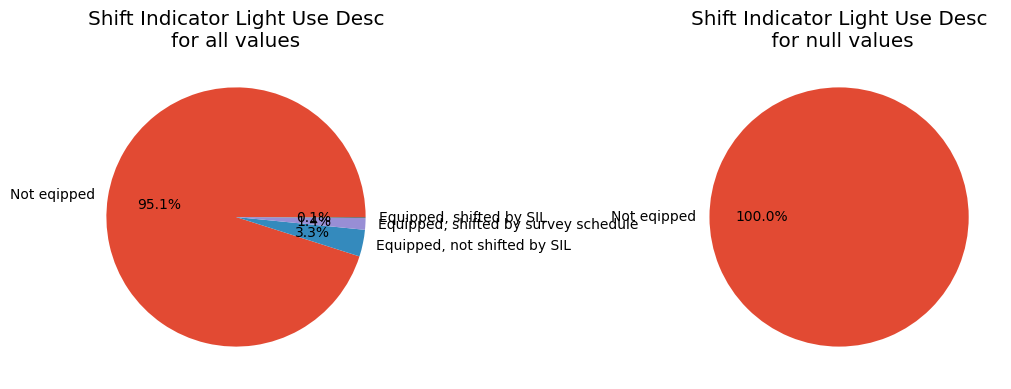

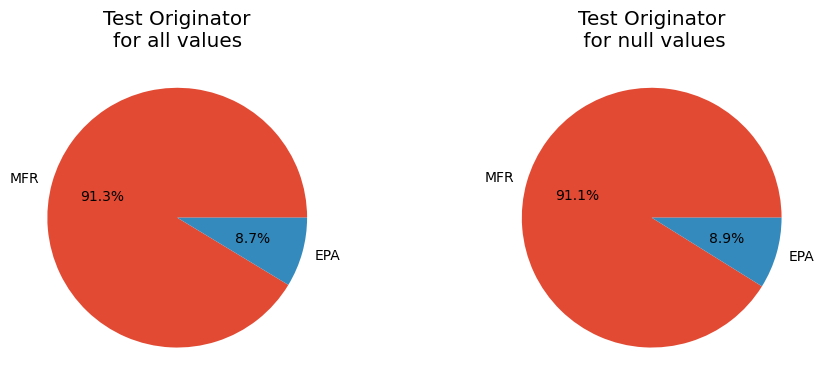

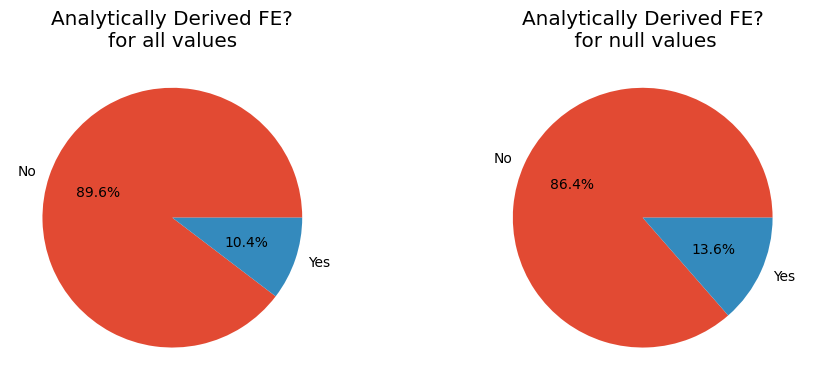

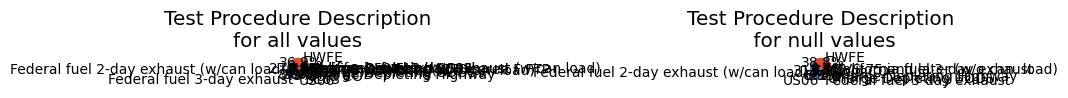

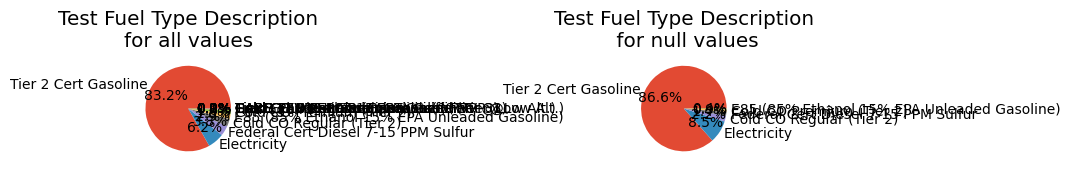

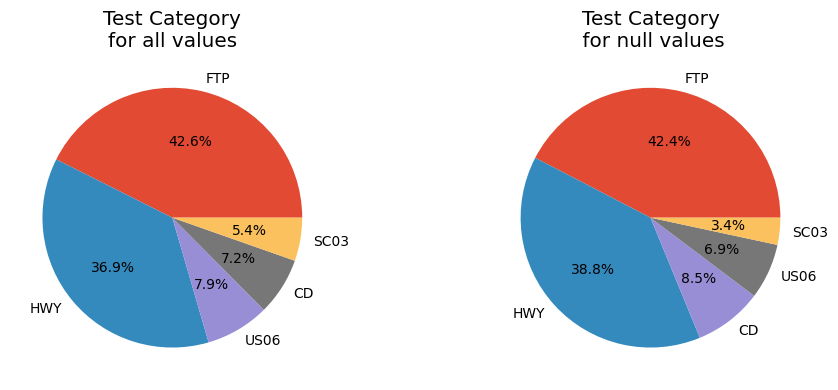

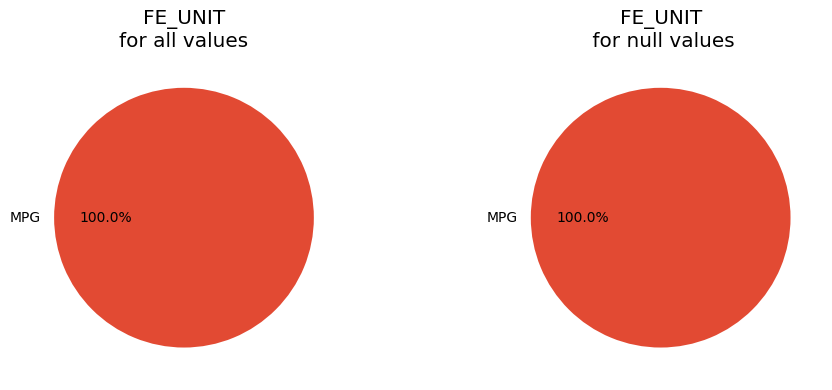

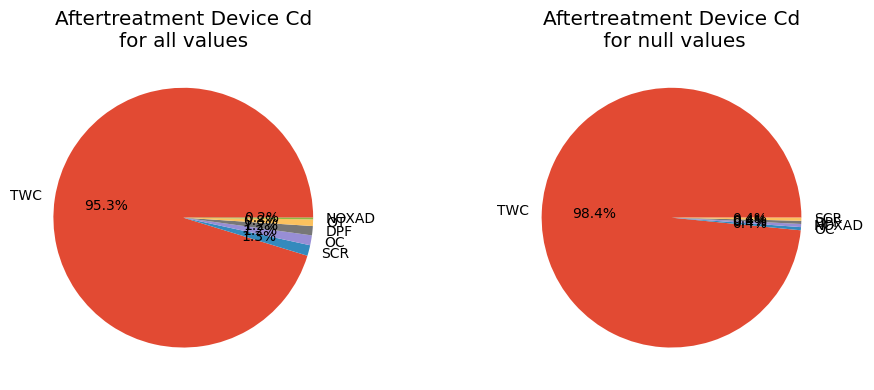

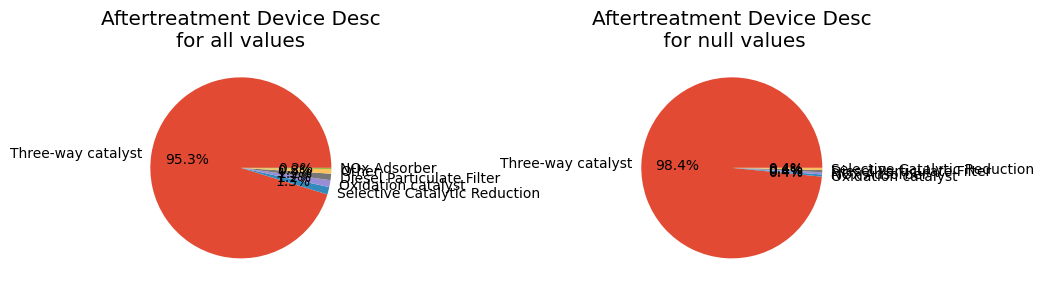

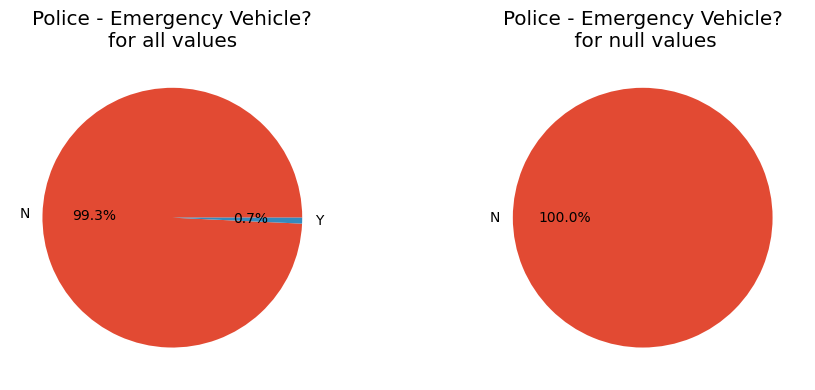

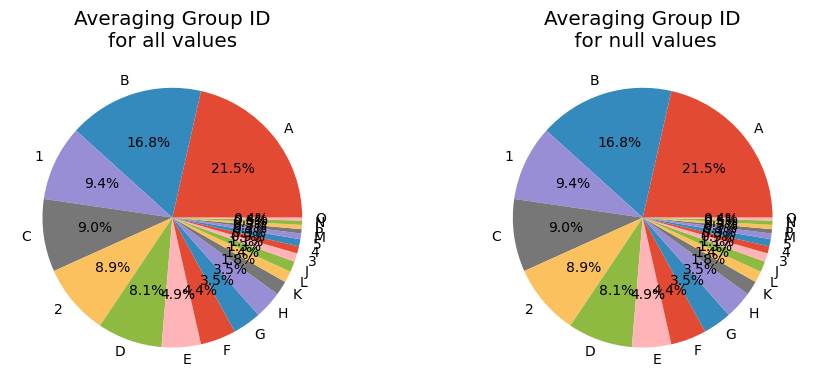

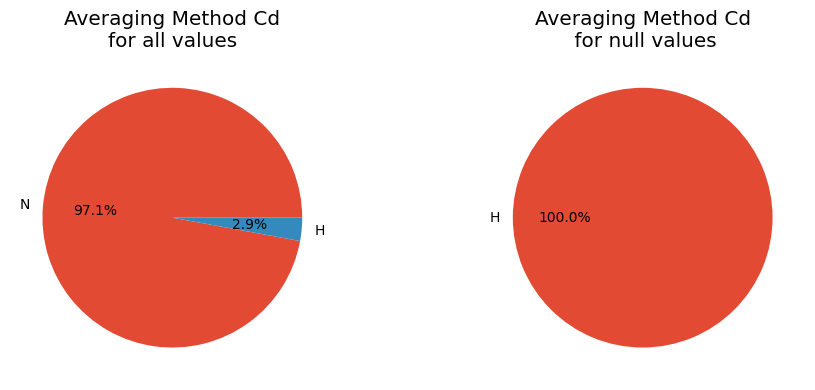

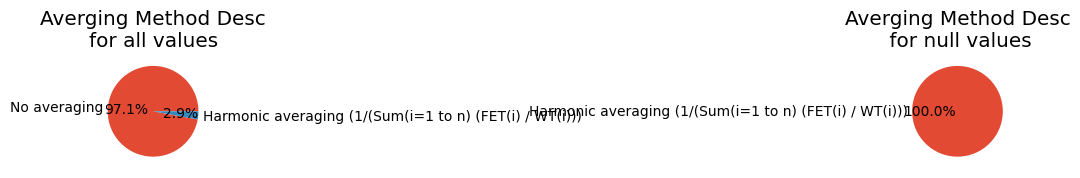

In [15]:
# On lance une évaluation pour voir les différences sur les proportions
# TODOalways (not false), just it is too long to run (5s)
if not False:
    categorical_data = df_clean.select_dtypes(exclude=[np.number])
    for column in categorical_data.columns:
        if df_comparision[column].nunique()<60:
            # if the repartition of values is different, print them in a pie plot
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns for side-by-side plots
            
            # Whole dataset pie chart
            axes[0].pie(df_comparision[column].value_counts(), 
                        labels=df_comparision[column].value_counts().index, 
                        autopct='%1.1f%%')
            axes[0].set_title(f"{column}\nfor all values")
            
            # Not-null values pie chart
            axes[1].pie(df_avg[column].value_counts(), 
                        labels=df_avg[column].value_counts().index, 
                        autopct='%1.1f%%')
            axes[1].set_title(f"{column}\n for null values")
            
            # Adjust layout and display
            plt.tight_layout()
            plt.show()
    


On observe que la réaprtition entre les données nulles et les données non nulls varie beaucoup pour: voiture, de la marque (Nissane), la propulsion (traction arrière), et la transimission (semi automatique).

Column: Test Veh Configuration #


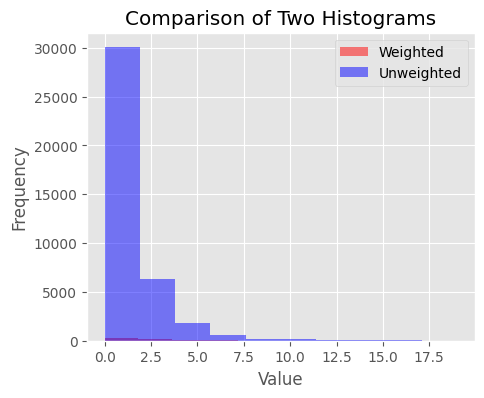

Column: Test Veh Displacement (L)


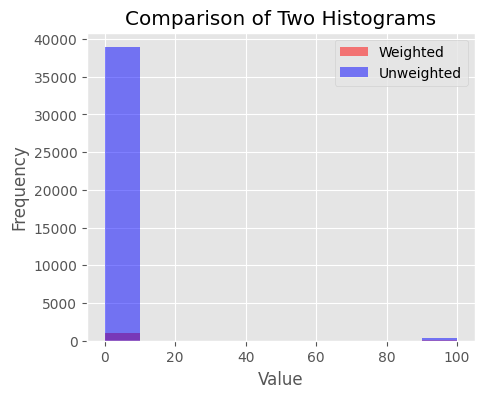

Column: PM (g/mi)


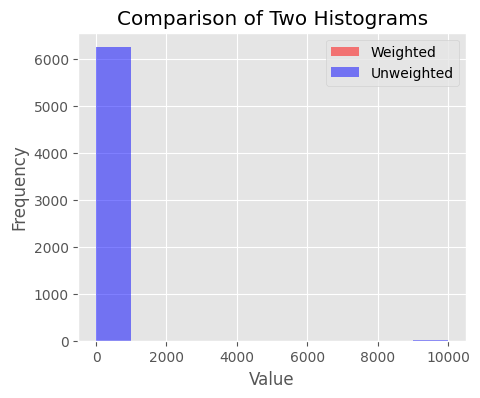

Column: CH4 (g/mi)


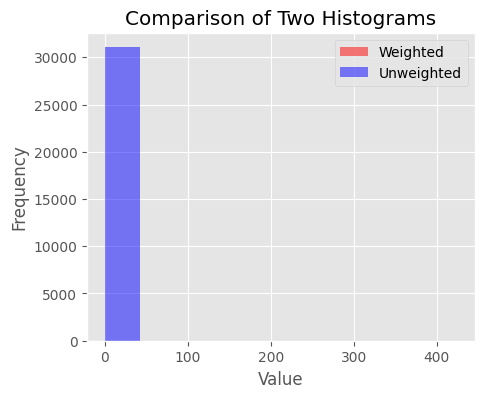

Column: DT-Energy Economy Rating


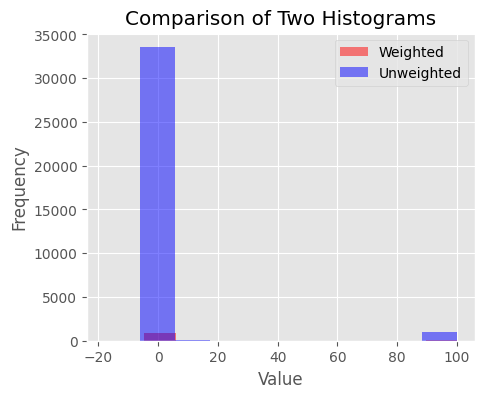

Column: Target Coef B (lbf/mph)


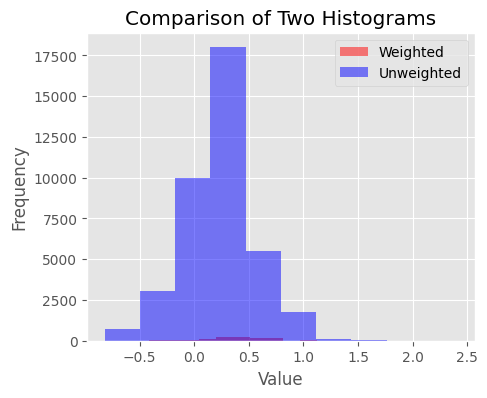

In [16]:
# Ici on compare pour la répartition

biggest_differences = ["Test Veh Configuration #","Test Veh Displacement (L)","PM (g/mi)","CH4 (g/mi)","DT-Energy Economy Rating","Target Coef B (lbf/mph)"]
for col in biggest_differences:
    print(f"Column: {col}")
    plt.figure(figsize=(5, 4))
    plt.hist(df_avg[col], color='red', alpha=0.5, label='Weighted')
    plt.hist(df_comparision[col], color='blue', alpha=0.5, label='Unweighted')
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Comparison of Two Histograms')
    plt.legend()

    # Display the plot
    plt.show()

En conclusion, il n'y a aucune raison évidente pour laquelle il y a des valeurs nulles, nous faisons donc l'hypothèse que la colonne n'a pas été complété lors de l'étude. Cette hyposthèse est renforcé par la répartition dans les diagrammes en fromage. On y observe la sur représentation de valeurs nulles dans des cas spécifiques (traction arrière, marque Nissane etc.).

#### aperçu global des erreurs possibles

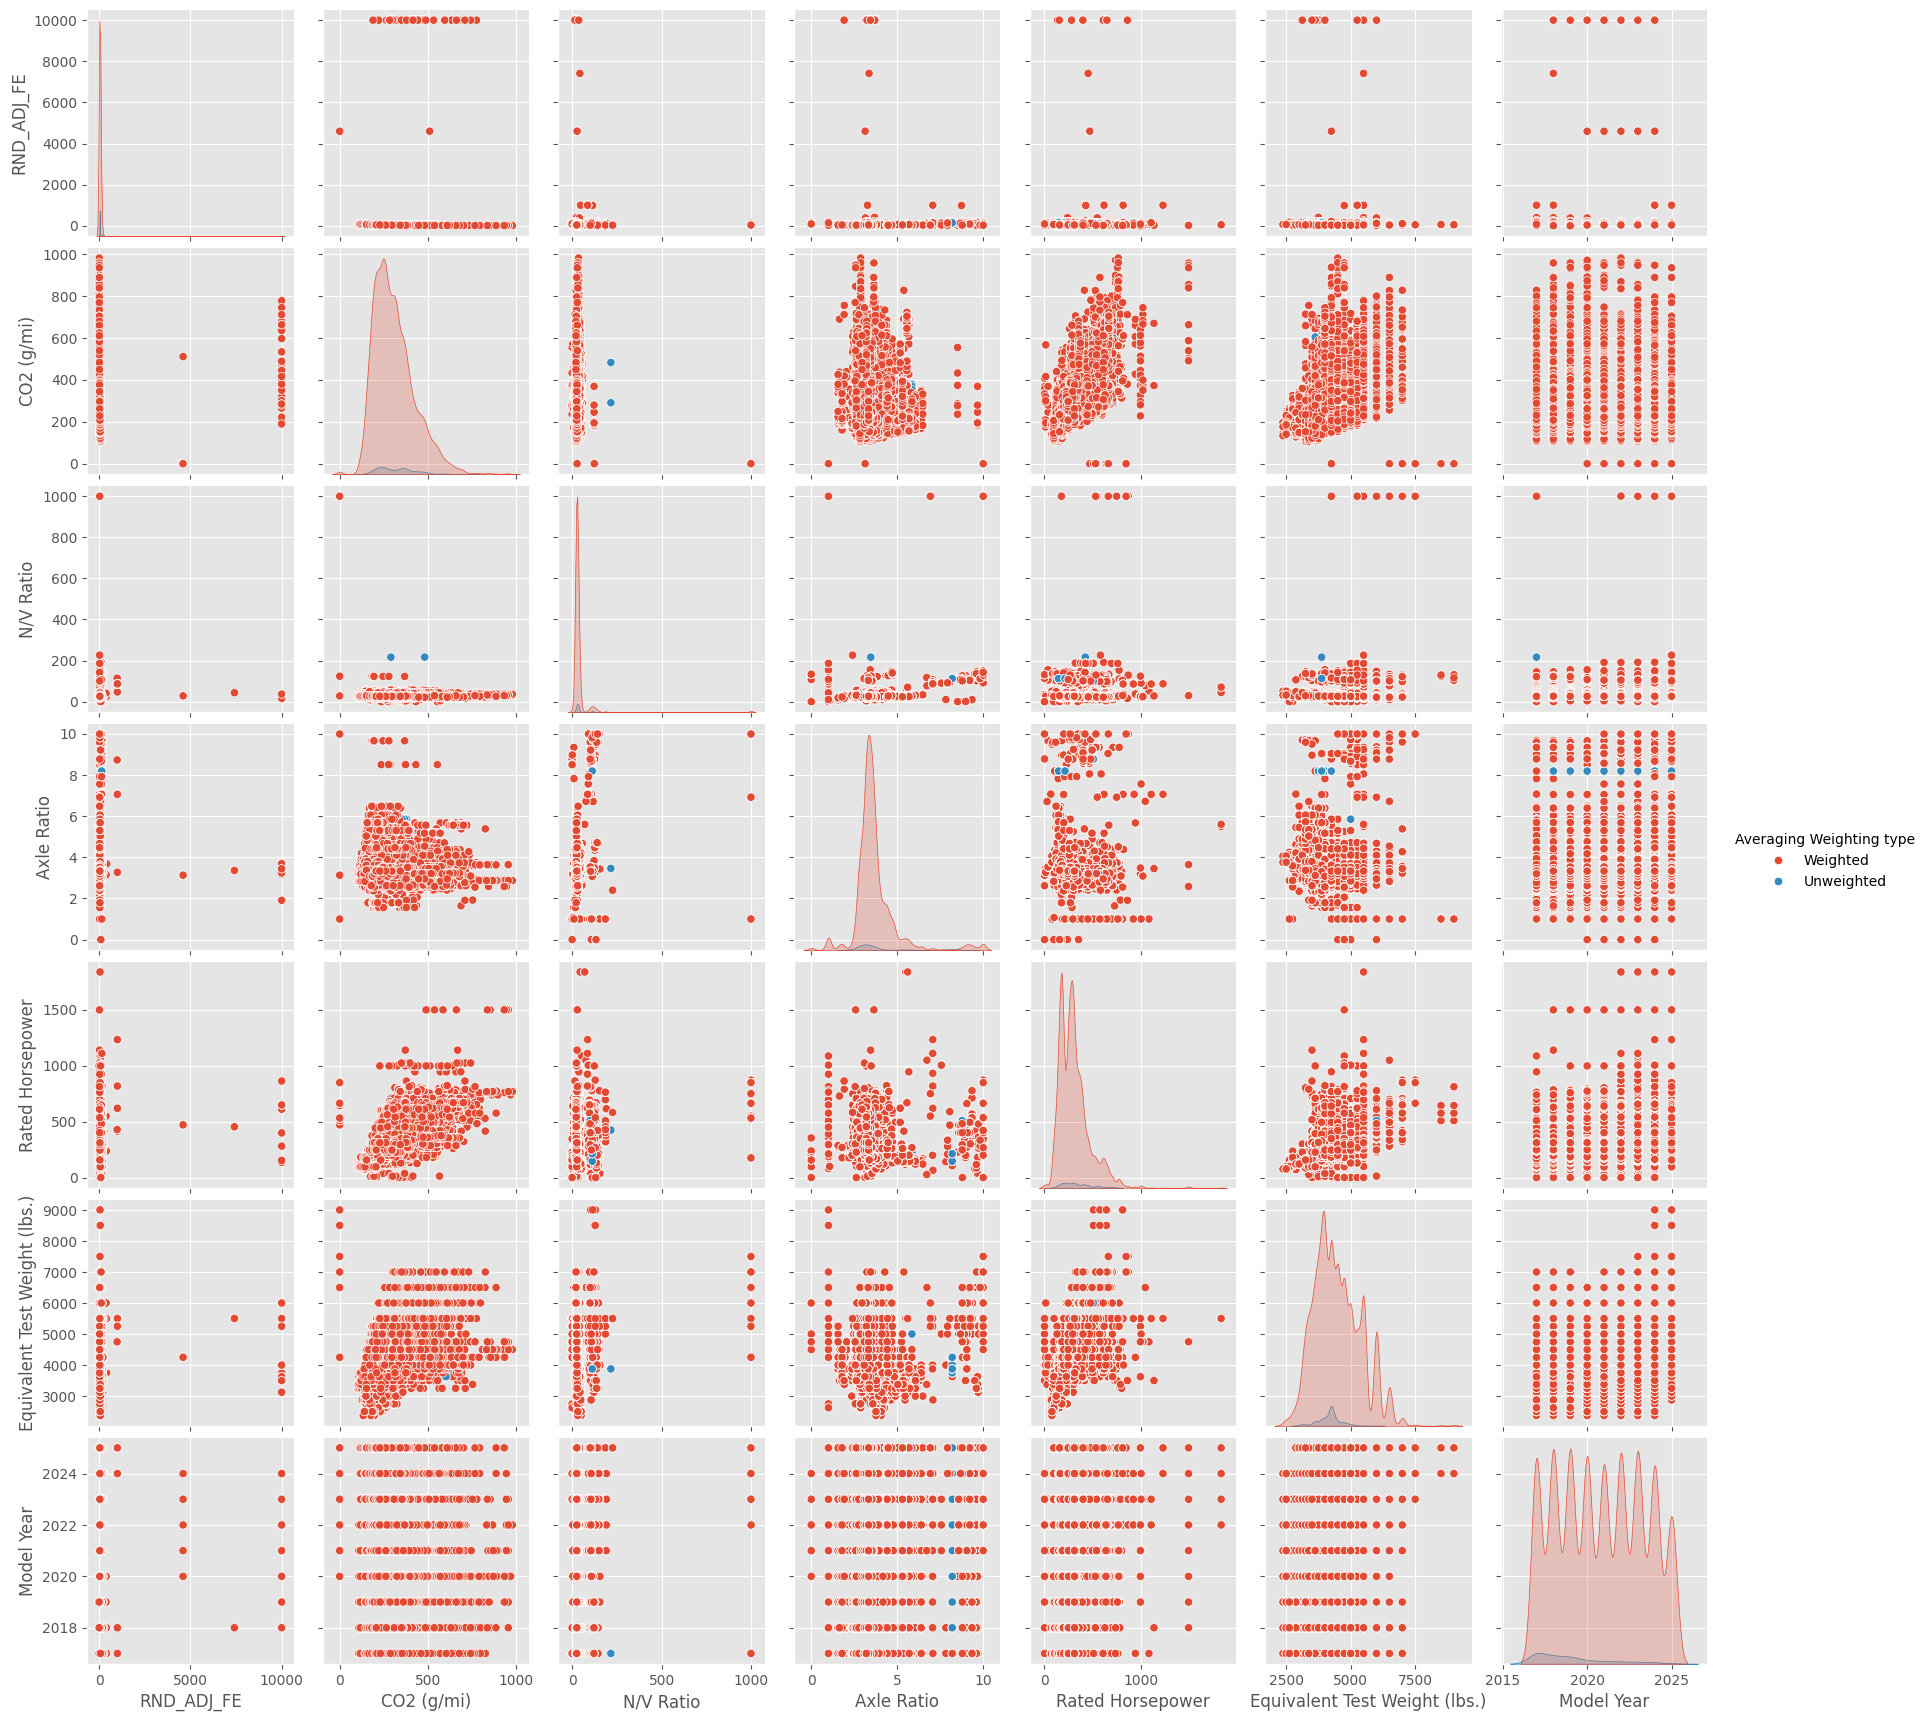

In [17]:
#TODO always (not false), just it is too long to run (2mn)
sns.pairplot(df_comparision[["RND_ADJ_FE", "FE_UNIT", "CO2 (g/mi)", "Test Fuel Type Description", "N/V Ratio", "Axle Ratio",  "Rated Horsepower", "Vehicle Manufacturer Name", "Tested Transmission Type", "Drive System Description", "Transmission Overdrive Desc", "Equivalent Test Weight (lbs.)", "Model Year", "Averaging Weighting type"]], 
             hue="Averaging Weighting type")


Cette autre visualitation nous confirme qu'il n'y a pas d'explication évidente à la présence de valeurs nulles.

### Trie des colonnes

explication de chaque colonnes
<ul>
<li>mpg - mpg(fuel economy, miles per gallon) Test level </li>
<li>C/H - city (C) or highway (H) test identifier </li>
<li>fuel - fuel type code </li>
<li>n/v - n/v ratio (engine speed versus vehicle speed at 50 mph)</li>
<li>axle - axle ratio</li>
<li>etw - equivalent test weight</li>
<li>od - overdrive code</li>
<li>drv - drive system code</li>
<li>evc - evaporative emission control system code </li>
<li>trns - transmission code </li>
<li>rhp - rated horsepower </li>
<li>car/truck - ‘C’ for passenger vehicle and ‘T’ for truck (classification of the tested vehicle) </li>
<li>carline - car line name (test vehicle model name) </li>
<li>bidx</li>
<li>Mfr - Code Manufacturer Name</li>
</ul>

In [18]:
# keep only useful columns
columns_wee_keep = ["RND_ADJ_FE", "FE_UNIT", "Test Fuel Type Description", "N/V Ratio", "Axle Ratio",  "Rated Horsepower", "Veh Mfr Code", "Tested Transmission Type", "Drive System Description", "Transmission Overdrive Desc", "Equivalent Test Weight (lbs.)", "Model Year", "THC (g/mi)", "CO (g/mi)", "CO2 (g/mi)", "NOx (g/mi)", "PM (g/mi)", "CH4 (g/mi)", "N2O (g/mi)"]
# and we get the column mph

df2 = df_clean[columns_wee_keep]

#### Convertion en données lisibles

##### Passage de la pollution à l'unité: tonnes équivalentes de CO2

In [19]:
# doing our own research we cam out with:
CO2_coef = {
    "Carbon Dioxide	": 1,
    "CO2": 1,
    "Carbon Monoxide": 1,
    "CO": 1,
    "Nitrogen Oxides": 298,
    "NOx": 298,
    "N2O": 298,
    "Methane": 25,  
    "CH4": 25,
    "Hydrocarbons": 1,
    "THC": 1,
}
df3 = df2.copy()
cols = ["THC (g/mi)", "CO (g/mi)", "CO2 (g/mi)", "NOx (g/mi)", "CH4 (g/mi)", "N2O (g/mi)", "PM (g/mi)"]
for col in cols:
    df3[col] = df3[col].apply(lambda x: 0 if math.isnan(x) else x)
    

df3["CO2 (eqg/mi)"] = df3.apply(lambda x:(
                              x["THC (g/mi)"]*CO2_coef["THC"]+
                              x["CO (g/mi)"]*CO2_coef["CO"]+
                              x["CO2 (g/mi)"]*CO2_coef["CO2"]+
                              x["NOx (g/mi)"]*CO2_coef["NOx"]+
                              x["CH4 (g/mi)"]*CO2_coef["CH4"]+
                              x["N2O (g/mi)"]*CO2_coef["N2O"])
                              , axis=1)
df3.head(2)                      
df3.drop(cols, axis=1, inplace=True)

##### Passer au système métrique

In [59]:
unit_convert = {
    "miles to kilometer": 1.60934,
    "lbs to kg": 0.453592,
}

df4 = df3.copy()

df4["litre pour 100km"] = df3.apply(lambda x: 235.214583/x["RND_ADJ_FE"] if x["FE_UNIT"] == "MPG" and x["RND_ADJ_FE"]>0 else 0, axis=1)
df4.drop(["RND_ADJ_FE", "FE_UNIT"], axis=1, inplace=True)


df4["Equivalent Test Weight (kg)"] = df4["Equivalent Test Weight (lbs.)"]*unit_convert["lbs to kg"]
df4["CO2 (eqg/km)"] = df4["CO2 (eqg/mi)"]*unit_convert["miles to kilometer"]

df4.drop(["CO2 (eqg/mi)", "Equivalent Test Weight (lbs.)"], axis=1, inplace=True)

##### Explicitation du nommage

In [60]:
#on observe les nommages obscures
for column in df4.columns:
    print(f"{column} has {len(set(df4[column]))} unique values:\n {set(df4[column])}\n")

print(df4.head(6) )


Test Fuel Type Description has 16 unique values:
 {'CARB LEV3 E10 Regular Gasoline', 'Cold CO Premium (Tier 2)', 'Cold CO E10 Regular Gasoline (Tier 3)', 'Federal Cert Diesel 7-15 PPM Sulfur', 'CARB Phase II Gasoline', 'Cold CO E10 Premium Gasoline (Tier 3)', 'Tier 3 E10 Regular Gasoline (9 RVP @Low Alt.)', 'Cold CO Diesel 7-15 ppm Sulfur', 'CARB LEV3 E10 Premium Gasoline', 'Tier 3 E10 Premium Gasoline (9 RVP @Low Alt.)', 'Tier 2 Cert Gasoline', 'E85 (85% Ethanol 15% EPA Unleaded Gasoline)', 'Hydrogen 5', 'Cold CO Regular (Tier 2)', 'Electricity', 'Cold CO Premium (CERT)'}

N/V Ratio has 457 unique values:
 {0.0, 4.2, 6.4, 9.1, 10.5, 9.7, 11.2, 9.4, 16.2, 17.3, 18.8, 19.2, 20.5, 21.7, 22.2, 23.4, 24.8, 24.9, 26.0, 26.9, 27.9, 27.0, 27.6, 27.5, 30.2, 28.7, 28.3, 28.2, 28.4, 29.1, 29.6, 32.7, 33.6, 41.0, 34.1, 34.0, 36.5, 37.0, 39.1, 44.0, 43.1, 40.3, 41.6, 44.2, 44.5, 45.3, 52.2, 52.4, 55.2, 48.9, 49.8, 50.6, 53.7, 56.2, 53.3, 56.5, 70.5, 77.4, 16.0, 85.7, 86.7, 85.9, 85.5, 90.3, 18.5, 

Rapport de démultiplication (_top gear ratio_): un rapport de démultiplication supérieur de 0,8:1 signifie que le moteur effectue 0,8 rotation pour chaque rotation des roues motrices.

De plus on change Transmission Overdrive Desc en rapport de démultiplication -> 0 ou 1

In [61]:
df4["Tier Standard"] = df4["Test Fuel Type Description"].apply(lambda x: 
    "2" if "Tier 3" in x or "LEV3" in x or "Phase II" in x else 
    "3" if "Tier 2" in x or "LEV2" in x  else 
    "4" if "Tier 1" in x or "LEV1" in x  or "E85" in x else 
    "0" if "Electricity" in x or "Hydrogen" in x else
    "2")
df4["Fuel type"] = df4["Test Fuel Type Description"].apply(lambda x: 
    "Electricity" if "Electricity" in x else
    "Hydrogen" if "Hydrogen" in x else 
    "E85" if "E85" in x else 
    "Diesel Cold" if "Cold" in x and "Diesel" in x else 
    "Diesel" if "Diesel" in x else 
    "E10 Premium Cold" if "Cold" in x and "E10" in x and "Premium" else
    "E10 Regular Cold" if "Cold" in x and "E10" in x and "Regular" else
    "E10 Premium" if "E10 Premium" in x or "" in x else
    "E10 Regular")
df4["Rear Type"] = df4["Drive System Description"].apply(lambda x:
    "Both" if "Partime" in x else
    "front" if "Front" in x else
    "back" if "Rear" in x else
    "4WD")
df4["Number of wheel"] = df4["Drive System Description"].apply(lambda x:
    "2" if "2" in x else
    "4" if "4" in x else
    "both" if "Part" in x else
    "4")

df4["Equivalent Test Weight (kg)"] = df4["Equivalent Test Weight (kg)"].replace(',', '', regex=True)
df4.drop(["Drive System Description", "Test Fuel Type Description"], axis=1, inplace=True)

In [62]:
df4.rename(columns={
    "Tested Transmission Type": "Transmission Type",
    "Transmission Overdrive Desc": "Gear ratio",
    "Equivalent Test Weight (kg)" : "Weight (kg)",
    }, inplace=True)
df4.head(2)

N/V Ratio  Axle Ratio  Rated Horsepower Veh Mfr Code Transmission Type  \
0     22.200       2.700               600          ASX    Semi-Automatic   
1     22.200       2.700               600          ASX    Semi-Automatic   

           Gear ratio  Model Year  litre pour 100km  Weight (kg)  \
0  Top gear ratio < 1        2017            12.511    2,041.164   
1  Top gear ratio < 1        2017             7.612    2,041.164   

   CO2 (eqg/km) Tier Standard    Fuel type Rear Type Number of wheel  
0       766.471             3  E10 Premium      back               2  
1       464.048             3  E10 Premium      back               2

#### On modifie les types

In [63]:
df4["CO2 (eqg/km)"] = df4["CO2 (eqg/km)"].astype(int)
df4["Weight (kg)"] = df4["Weight (kg)"].astype(float)

#### Quelques variables utiles (pour plus tard)

In [64]:
# numerical data
numerical_columns = df4.select_dtypes(include=[np.number]).columns

# categorical data
categorical_data = df4.select_dtypes(exclude=[np.number]).columns

## Traitement de données supplémentaire

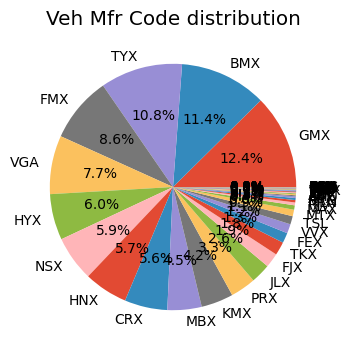

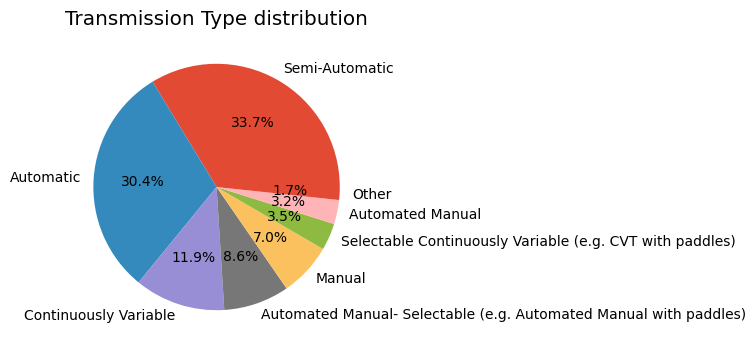

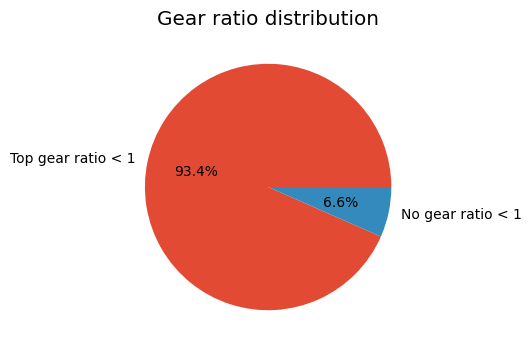

Gear ratio has a majority of values




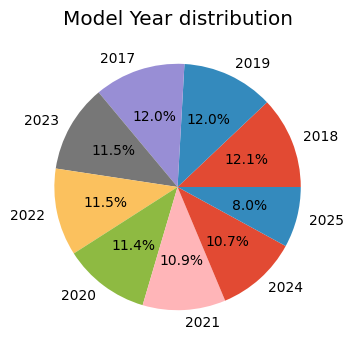

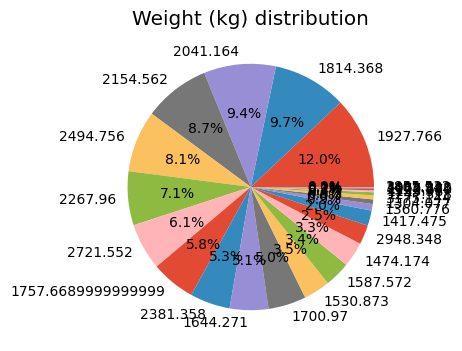

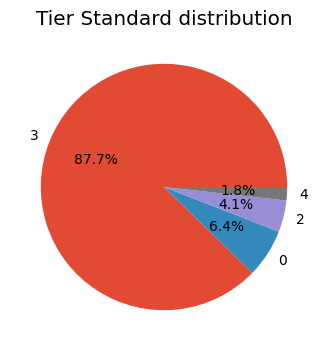

Tier Standard has a majority of values




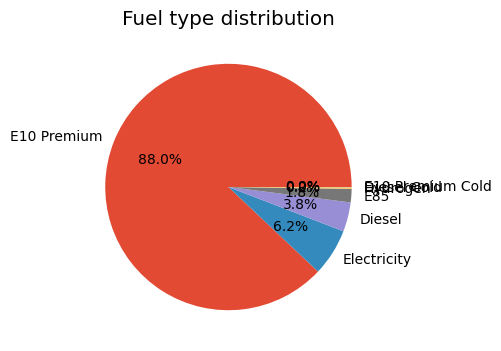

Fuel type has a majority of values




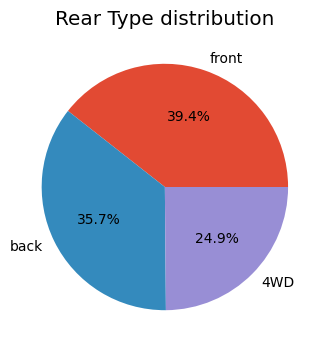

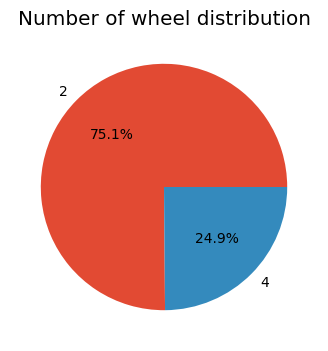

Number of wheel has a majority of values




['Gear ratio', 'Tier Standard', 'Fuel type', 'Number of wheel']

In [65]:
uniqueness_cols = []
for col in df4:
    if df4[col].nunique() < 60:
        # print a pie chart for the number of diffrent values
        plt.figure(figsize=(5, 4))
        plt.pie(df4[col].value_counts(), labels=df4[col].value_counts().index, autopct='%1.1f%%')
        plt.title(f"{col} distribution")
        plt.show()
        
        # only for the columns with a repartition of values that are at least 50% on value
        if df4[col].value_counts().max() > df4[col].shape[0]*0.5:
            print(f"{col} has a majority of values")
            print("\n")
            uniqueness_cols.append(col)
uniqueness_cols

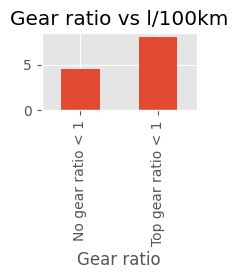

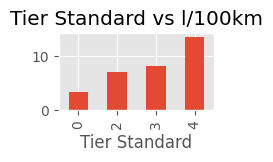

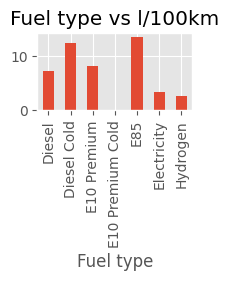

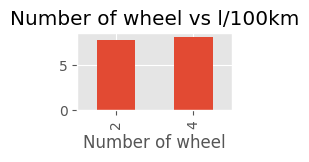

In [66]:
 # soit l'output de la cellule au dessus
columns_polarized = ['Gear ratio', 'Tier Standard', 'Fuel type', 'Number of wheel']

for col in columns_polarized:
    # plot a histogram that has a bar with the average consumption for each value of col
    plt.figure(figsize=(2, 1))
    df4.groupby(col)["litre pour 100km"].mean().plot(kind='bar')
    plt.title(f"{col} vs l/100km")
    plt.show()

number of wheel n'a pas d'impact significatif sur la variable objectif alors que la répartition des valeurs et très polarisé. On ne conserve pas cette colonne. (avoir 4 roue motrices est un évènement rare et pas impactant)

In [67]:
df4.drop(["Number of wheel"], axis=1, inplace=True)

##### passage de données ordonnales à numérique (et identification des données catérgorielles)

On  étant catégorielles on les divises en deux classes: ordinale (catégorielle avec ordre) et nominal (catégorielle sans ordre) 

variables ordonnales

* Gear ratio
* Tier Standard
* Fuel type

variable nominales
* Veh Mfr Code
* Transmission Type
* Rear Type

##### Traitement ordinales
Après des recherches on choisi de hierarchisé fuel type par densité énergétique comme suit:    
1. Hydrogen
2. E85
3. E10 Premium Cold
4. E10 Premium
5. Diesel Cold
6. Diesel
7. Electricity


De même pour tier standard:
1. 0
2. 1
3. 3
4. 4

Pour Gear Ratio:
1. Top gear ratio < 1
2. No gear ratio < 1

In [134]:
df42 = df4.copy()

fuel_cat_to_num = {"Hydrogen":1, "E85":2, "E10 Premium Cold":3, "E10 Premium":4, "Diesel Cold":5, "Diesel":6, "Electricity":7}
tierstand_cat_to_num = {"0": 1,"1": 2, "2": 3, "3": 4,"4": 5}
gear_ratio_cat_to_num = {"Top gear ratio < 1": 0, "No gear ratio < 1": 1}

df42["Fuel type"] = df42["Fuel type"].apply(lambda x: fuel_cat_to_num[x])
df42["Tier Standard"] = df42["Tier Standard"].apply(lambda x: tierstand_cat_to_num[x])
df42["Gear ratio"] = df42["Gear ratio"].apply(lambda x: gear_ratio_cat_to_num[x])
df42["Gear ratio"].value_counts()

0    36597
1     2585
Name: Gear ratio, dtype: int64

##### Traitement nominal
Plusieurs type de traitement sont possible:
* OneHotEncoding (très adapté si peu de valeurs différentes)
* Label Encoding (si deux catégories)
* Mean Encoding (mais risque d'overfitting)

variable nominales
* Veh Mfr Code
* Transmission Type
* Rear Type

In [135]:
from sklearn.preprocessing import OneHotEncoder

def mean_encoding(df, col):
    mean_encoding = df42.groupby(col)['litre pour 100km'].mean()
    df[f"{col} Mean Encoding"] = df[col].map(mean_encoding)
    df.drop(columns=[col], inplace=True)
    return df   

def onehotencoding(df, col):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_features = encoder.fit_transform(df[[col]])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out([col]))
    # Fusion des données encodées avec le DataFrame original
    df_encoded = pd.concat([df.drop(columns=[col]), encoded_df], axis=1)
    return df_encoded

df42 = mean_encoding(df42, "Veh Mfr Code")
df42 = mean_encoding(df42, "Transmission Type")
df42 = onehotencoding(df42, "Rear Type")

In [136]:
df42.describe()

N/V Ratio  Axle Ratio  Rated Horsepower  Gear ratio  Model Year  \
count 39,182.000  39,182.000        39,182.000  39,182.000  39,182.000   
mean      35.954       3.675           306.834       0.066   2,020.791   
std       66.104       1.265           158.673       0.248       2.523   
min        0.000       0.000             1.000       0.000   2,017.000   
25%       24.000       3.150           185.000       0.000   2,019.000   
50%       26.400       3.420           280.000       0.000   2,021.000   
75%       30.900       3.820           375.000       0.000   2,023.000   
max      999.900       9.990         1,839.000       1.000   2,025.000   

       litre pour 100km  Weight (kg)  CO2 (eqg/km)  Tier Standard  Fuel type  \
count        39,182.000   39,182.000    39,182.000     39,182.000 39,182.000   
mean              7.809    2,023.471       469.329          3.785      4.222   
std               4.012      401.111       967.698          0.766      0.866   
min               0.000    1,077.281         0.000          1.000      1.000   
25%               5.561    1,757.669       334.000          4.000      4.000   
50%               7.397    1,927.766       446.000          4.000      4.000   
75%               9.680    2,267.960       593.000          4.000      4.000   
max             261.350    4,082.328   152,218.000          5.000      7.000   

       Veh Mfr Code Mean Encoding  Transmission Type Mean Encoding  \
count                  39,182.000                       39,182.000   
mean                        7.809                            7.809   
std                         1.439                            1.230   
min                         0.024                            2.855   
25%                         6.753                            7.886   
50%                         7.680                            8.376   
75%                         8.994                            8.495   
max                        16.378                            8.495   

       Rear Type_back  Rear Type_front  
count      39,182.000       39,182.000  
mean            0.357            0.394  
std             0.479            0.489  
min             0.000            0.000  
25%             0.000            0.000  
50%             0.000            0.000  
75%             1.000            1.000  
max             1.000            1.000

## Traitement des valeurs extrêmes

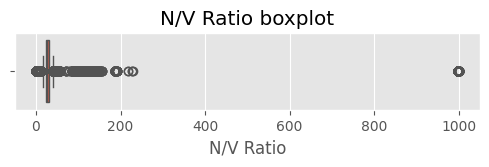

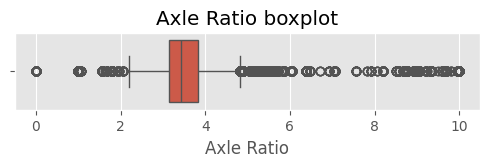

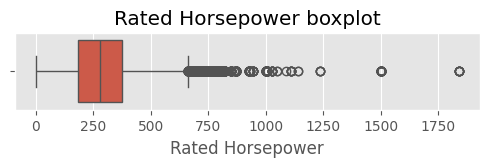

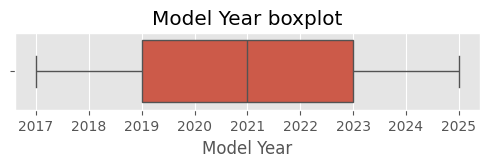

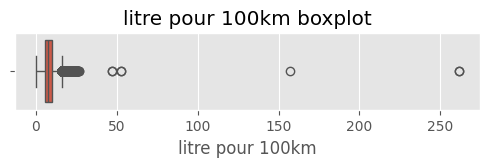

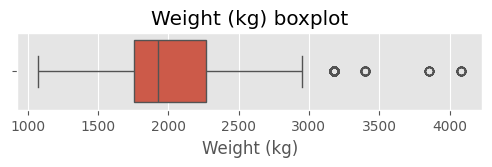

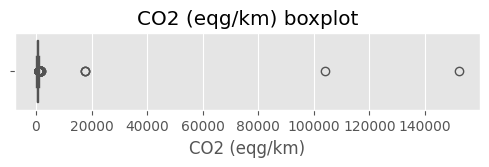

In [137]:
for numerical_column in numerical_columns:
    #plot the boxplot for each numerical column
    plt.figure(figsize=(6, 1))
    sns.boxplot(x=df42[numerical_column])
    plt.title(f"{numerical_column} boxplot")
    plt.show()

In [138]:
# for each numerical column, print the number of outliers
from tabulate import tabulate
result = []
outlayers_border = {}
for numerical_column in numerical_columns:
    q1 = df42[numerical_column].quantile(0.25)
    q3 = df42[numerical_column].quantile(0.75)
    interquartilrange = q3 - q1
    lower_bound = q1 - 1.5*interquartilrange
    upper_bound = q3 + 1.5*interquartilrange
    total_outlaiers = len(df42[(df42[numerical_column]<lower_bound) | (df42[numerical_column]>upper_bound)])
    outlayers_border[numerical_column] = (lower_bound, upper_bound)
    result.append((numerical_column,total_outlaiers,(total_outlaiers*100/df42.shape[0]), lower_bound, upper_bound))
print(tabulate(result, headers=["Column", "Number of outliers", "Ratio of outliers in %", "lower limit", "upper limit"]))

Column              Number of outliers    Ratio of outliers in %    lower limit    upper limit
----------------  --------------------  ------------------------  -------------  -------------
N/V Ratio                         3755                  9.58348       13.65            41.25
Axle Ratio                        4535                 11.5742         2.145            4.825
Rated Horsepower                  1337                  3.41228     -100              660
Model Year                           0                  0           2013             2029
litre pour 100km                   897                  2.28932       -0.617848        15.8581
Weight (kg)                        263                  0.671227     992.232         3033.4
CO2 (eqg/km)                       706                  1.80185      -54.5            981.5


On remarque des répartition parfois très hétérogène comme le montre un nombre important de valeures extrêmes pour _Axle Ratio_.

#### Résolution et explication des valeures extrêmes

In [139]:
# On tente de comprendre l'origine des valeures extrèmes. Sont-elles aberrantes ou bien sont-elles des valeurs rares mais importantes?

df42['Index'] = range(1, len(df42) + 1)
outliers_dict = {}
outlayers_columns = ['N/V Ratio', 'Axle Ratio', 'Rated Horsepower', 'litre pour 100km', 'Weight (kg)', 'CO2 (eqg/km)']
for key in outlayers_columns:
    outliers_dict[key] = list(df42[(df42[key] < outlayers_border[key][0]) | (df42[key] > outlayers_border[key][1])]["Index"])

print("outlier example:")
df42.iloc[outliers_dict["CO2 (eqg/km)"][0:5]]


outlier example:


N/V Ratio  Axle Ratio  Rated Horsepower  Gear ratio  Model Year  \
7      33.600       3.730               568           0        2017   
35     27.200       3.080               560           0        2017   
53     23.400       2.850               520           0        2017   
58     23.400       2.850               520           0        2017   
63     24.900       2.850               616           0        2017   

    litre pour 100km  Weight (kg)  CO2 (eqg/km)  Tier Standard  Fuel type  \
7             10.501    1,927.766           638              4          4   
35            13.836    2,154.562           854              4          4   
53            11.418    2,721.552           697              4          4   
58            10.227    2,494.756           625              4          4   
63            17.295    2,721.552          1074              4          4   

    Veh Mfr Code Mean Encoding  Transmission Type Mean Encoding  \
7                       10.315                            7.896   
35                      10.799                            7.886   
53                      10.799                            8.495   
58                      10.799                            8.495   
63                      13.960                            8.495   

    Rear Type_back  Rear Type_front  Index  
7            1.000            0.000      8  
35           0.000            0.000     36  
53           0.000            0.000     54  
58           0.000            0.000     59  
63           0.000            1.000     64

In [140]:
# Les valeurs extrêmes sont-elles liées à des véhicules aux dimensions générallement extrêmes où sont-elles répartit au sein de plusieurs individus?
# Par exemple un camion aura probablement une puissance, une consommation et un poids extrême, il sera alors intéressant de créer une catégorie camion
# Creating the intersection table (double-entry table)
intersection_table = pd.DataFrame(0, index=outlayers_columns, columns=outlayers_columns)
# Counting the intersection of outliers between each pair of categories
for row_category in outlayers_columns:
    for col_category in outlayers_columns:
        a = set(outliers_dict[row_category]) 
        b = set(outliers_dict[col_category])
        if len(a) == 0 or len(b) == 0:
            intersection_table.loc[row_category, col_category]=-1
        else:
            intersection_table.loc[row_category, col_category]=len(a&b)*100/min(len(a), len(b))
intersection_table

N/V Ratio  Axle Ratio  Rated Horsepower  litre pour 100km  \
N/V Ratio           100.000      54.594            24.981             4.125   
Axle Ratio           54.594     100.000            31.563             7.023   
Rated Horsepower     24.981      31.563           100.000            35.117   
litre pour 100km      4.125       7.023            35.117           100.000   
Weight (kg)          81.369      83.650            58.175             6.844   
CO2 (eqg/km)          4.533       9.065            42.918            95.184   

                  Weight (kg)  CO2 (eqg/km)  
N/V Ratio              81.369         4.533  
Axle Ratio             83.650         9.065  
Rated Horsepower       58.175        42.918  
litre pour 100km        6.844        95.184  
Weight (kg)           100.000         6.844  
CO2 (eqg/km)            6.844       100.000

Sachant que le nombre d'outlier de la colonne avec le plus d'outlier est de 10% des valeurs, on remarque les outliers sont parfois outliers sur deux catégories, on tente de voir s'il y a plus (80% de valeurs extrêmes partagées entre N/V ratio et Weight).

In [141]:
all_outlaiers=[a for val in outliers_dict.values() for a in val]
print(f"Number of outliers cumulative: {len(all_outlaiers)}")
full_intersection = set()
for key in outlayers_columns:
    full_intersection = full_intersection & set(outliers_dict[key])
print(f"Number of outliers intersect (except weight and CO2): {len(full_intersection)}")

Number of outliers cumulative: 11493
Number of outliers intersect (except weight and CO2): 0


Ainsi les valeurs extrêmes sont présente parfois extrêmes sur plusieurs catégrories, mais aucune n'est extrêmes sur toutes les catégories. Il n'y a donc pas de catégories extrêmes.

On choisi de les supprimer.

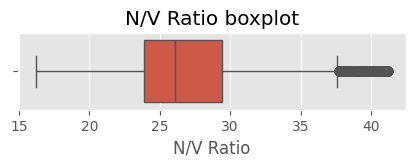

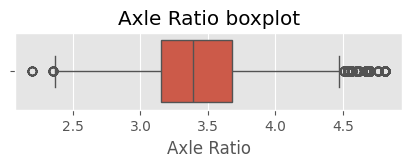

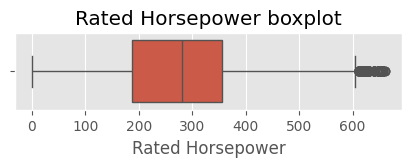

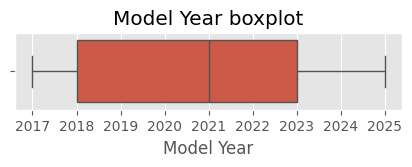

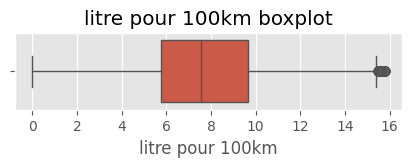

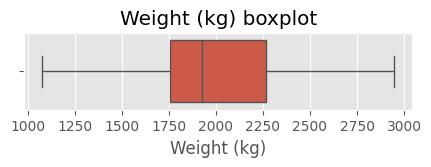

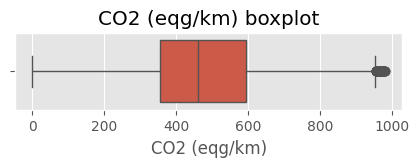

In [142]:
df5 = df42[~df42["Index"].isin(all_outlaiers)]
for numerical_column in numerical_columns:
    #plot the boxplot for each numerical column
    plt.figure(figsize=(5, 1))
    sns.boxplot(x=df5[numerical_column])
    plt.title(f"{numerical_column} boxplot")
    plt.show()

## Analyse des données

__important features__<br>
* CO2 geq/km is our target variable
* we want to understand wich variables are the most relevant


In [143]:
df_vis = df5.copy().dropna()

#### correlation

<Axes: >

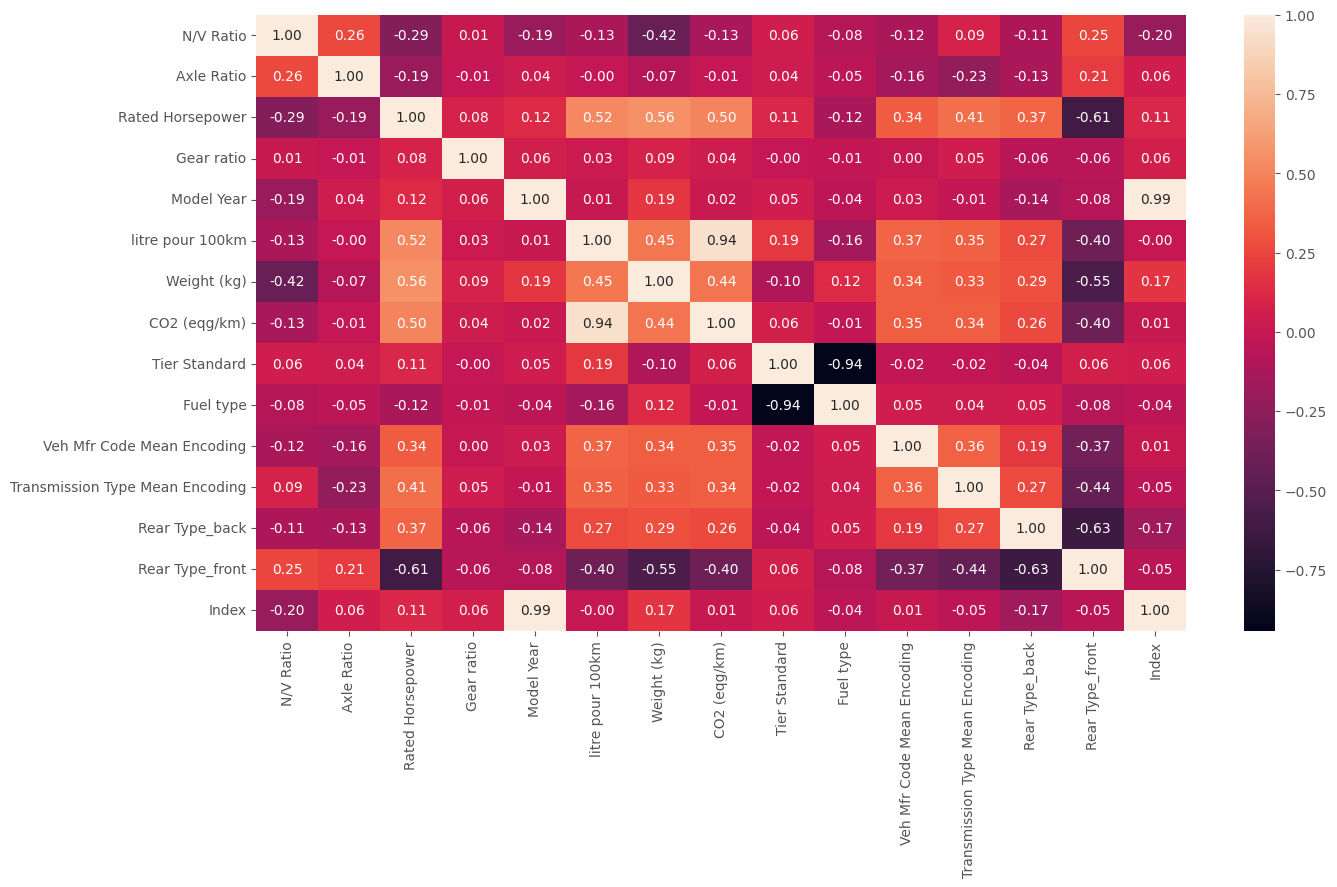

In [144]:
# correlation matrix
corr = df_vis.corr()
columns_to_drop= []
sns.heatmap(corr, annot=True, fmt=".2f")

On remarque pas de corrélation importante exceptés les évidentes: 
* consommation et émission eqCO2
* Index et année (puisque le dataframe et indexé chronoliquement)
* Tier Standard et Fuel Type (assez compréhensible)


In [145]:
df_vis["Gear ratio"].value_counts()

0    31082
1      364
Name: Gear ratio, dtype: int64

In [146]:
columns_to_drop.append("Fuel type")
columns_to_drop.append("Gear ratio")

##### Corrélation Poids/Puissance
La plus grosse corrélation intéressante et entre la puissance (_rated horse power_) et le poids de test. Cette légère corrélation (0.56) s'explique parceque plus une voiture est lourde plus l'énergie nécessaire pour la faire rouler est importante :

$E_c = \frac{1}{2} m v^2$

RMSE: 315.67


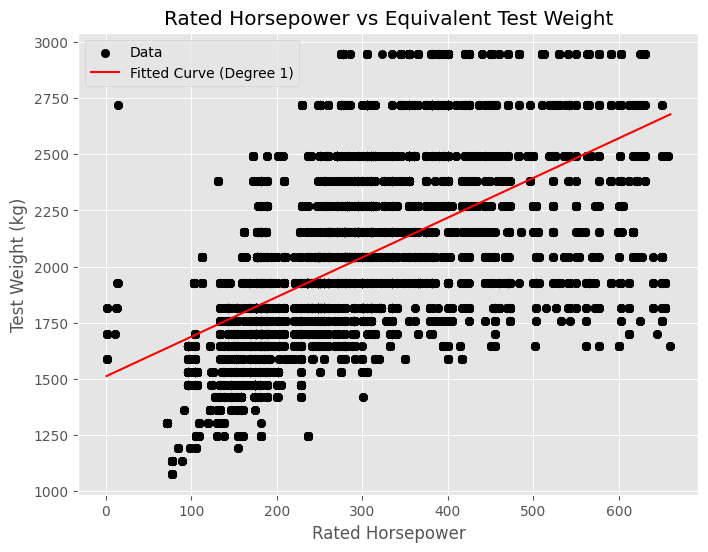

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Extract the data
X = df_vis["Rated Horsepower"].values.reshape(-1, 1)  # Independent variable
y = df_vis["Weight (kg)"].values  # Dependent variable

# Fit a polynomial regression model (e.g., degree 2)
degree = 1
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

# Train the model
model = LinearRegression()
model.fit(X_poly, y)

# Predict values
y_pred = model.predict(X_poly)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE: {rmse:.2f}")

# Generate values for the curve
X_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
X_range_poly = poly.transform(X_range)
y_range_pred = model.predict(X_range_poly)

# Plot the scatter plot and the curve
plt.figure(figsize=(8, 6))
plt.scatter(df_vis["Rated Horsepower"], df_vis["Weight (kg)"], color='black', label="Data")
plt.plot(X_range, y_range_pred, color='red', label=f"Fitted Curve (Degree {degree})")
plt.xlabel("Rated Horsepower")
plt.ylabel("Test Weight (kg)")
plt.title("Rated Horsepower vs Equivalent Test Weight")
plt.legend()
plt.show()


On observe pas de ligne simple de tracage

#### PCA

In [148]:
# PCA
# Importing necessary libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load your data (replace with your dataset)
# For demonstration, using the iris dataset from sklearn as an example
X = df_vis[numerical_columns].drop(columns=["CO2 (eqg/km)"])  # Features
y = df_vis["CO2 (eqg/km)"]  # Labels

# Step 2: Standardize the data (PCA is affected by scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
# Create a PCA instance and specify the number of components to keep (e.g., 2 for 2D visualization)
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca.fit(X_scaled)

pca.components_



array([[-0.400, -0.183,  0.536,  0.184,  0.438,  0.542],
       [ 0.489,  0.666,  0.149, -0.201,  0.492,  0.109]])

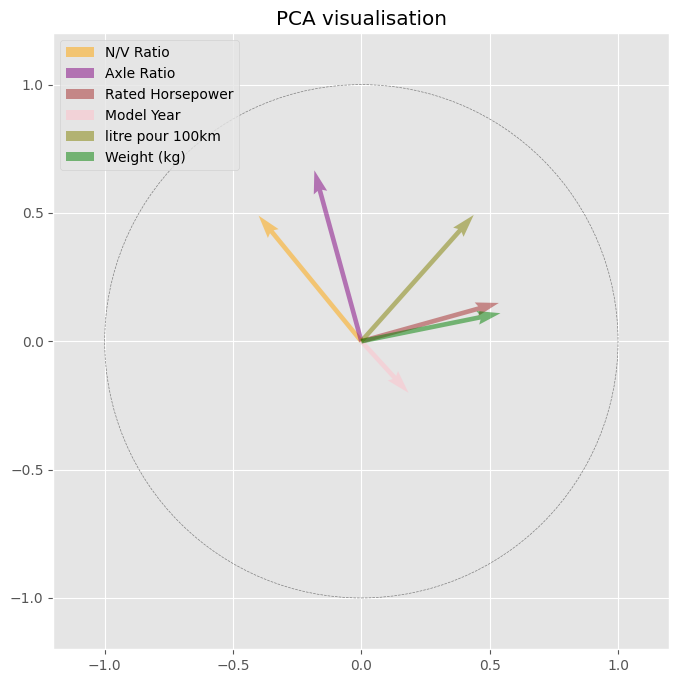

In [149]:
# Plotting
plt.figure(figsize=(8,8))
ax = plt.gca()

# Plot unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

# Plot the vectors
colors = ['orange', 'purple', 'brown', 'pink', 'olive', 'green']
for i in range(pca.components_.shape[1]):
    ax.quiver(0, 0, pca.components_[0, i], pca.components_[1, i], angles='xy', scale_units='xy', scale=1, color=colors[i], alpha=0.5,
              label=numerical_columns[i])


# Setting the aspect ratio of the plot to be equal
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_aspect('equal')

# Add labels and title
plt.legend(loc='upper left')
plt.title("PCA visualisation")

# Show the plot
plt.grid(True)
plt.show()

Sans surprise on remarque la proximité d'expression en le poids et les chevaux développé.




#### pairplot pour analyser la distribution

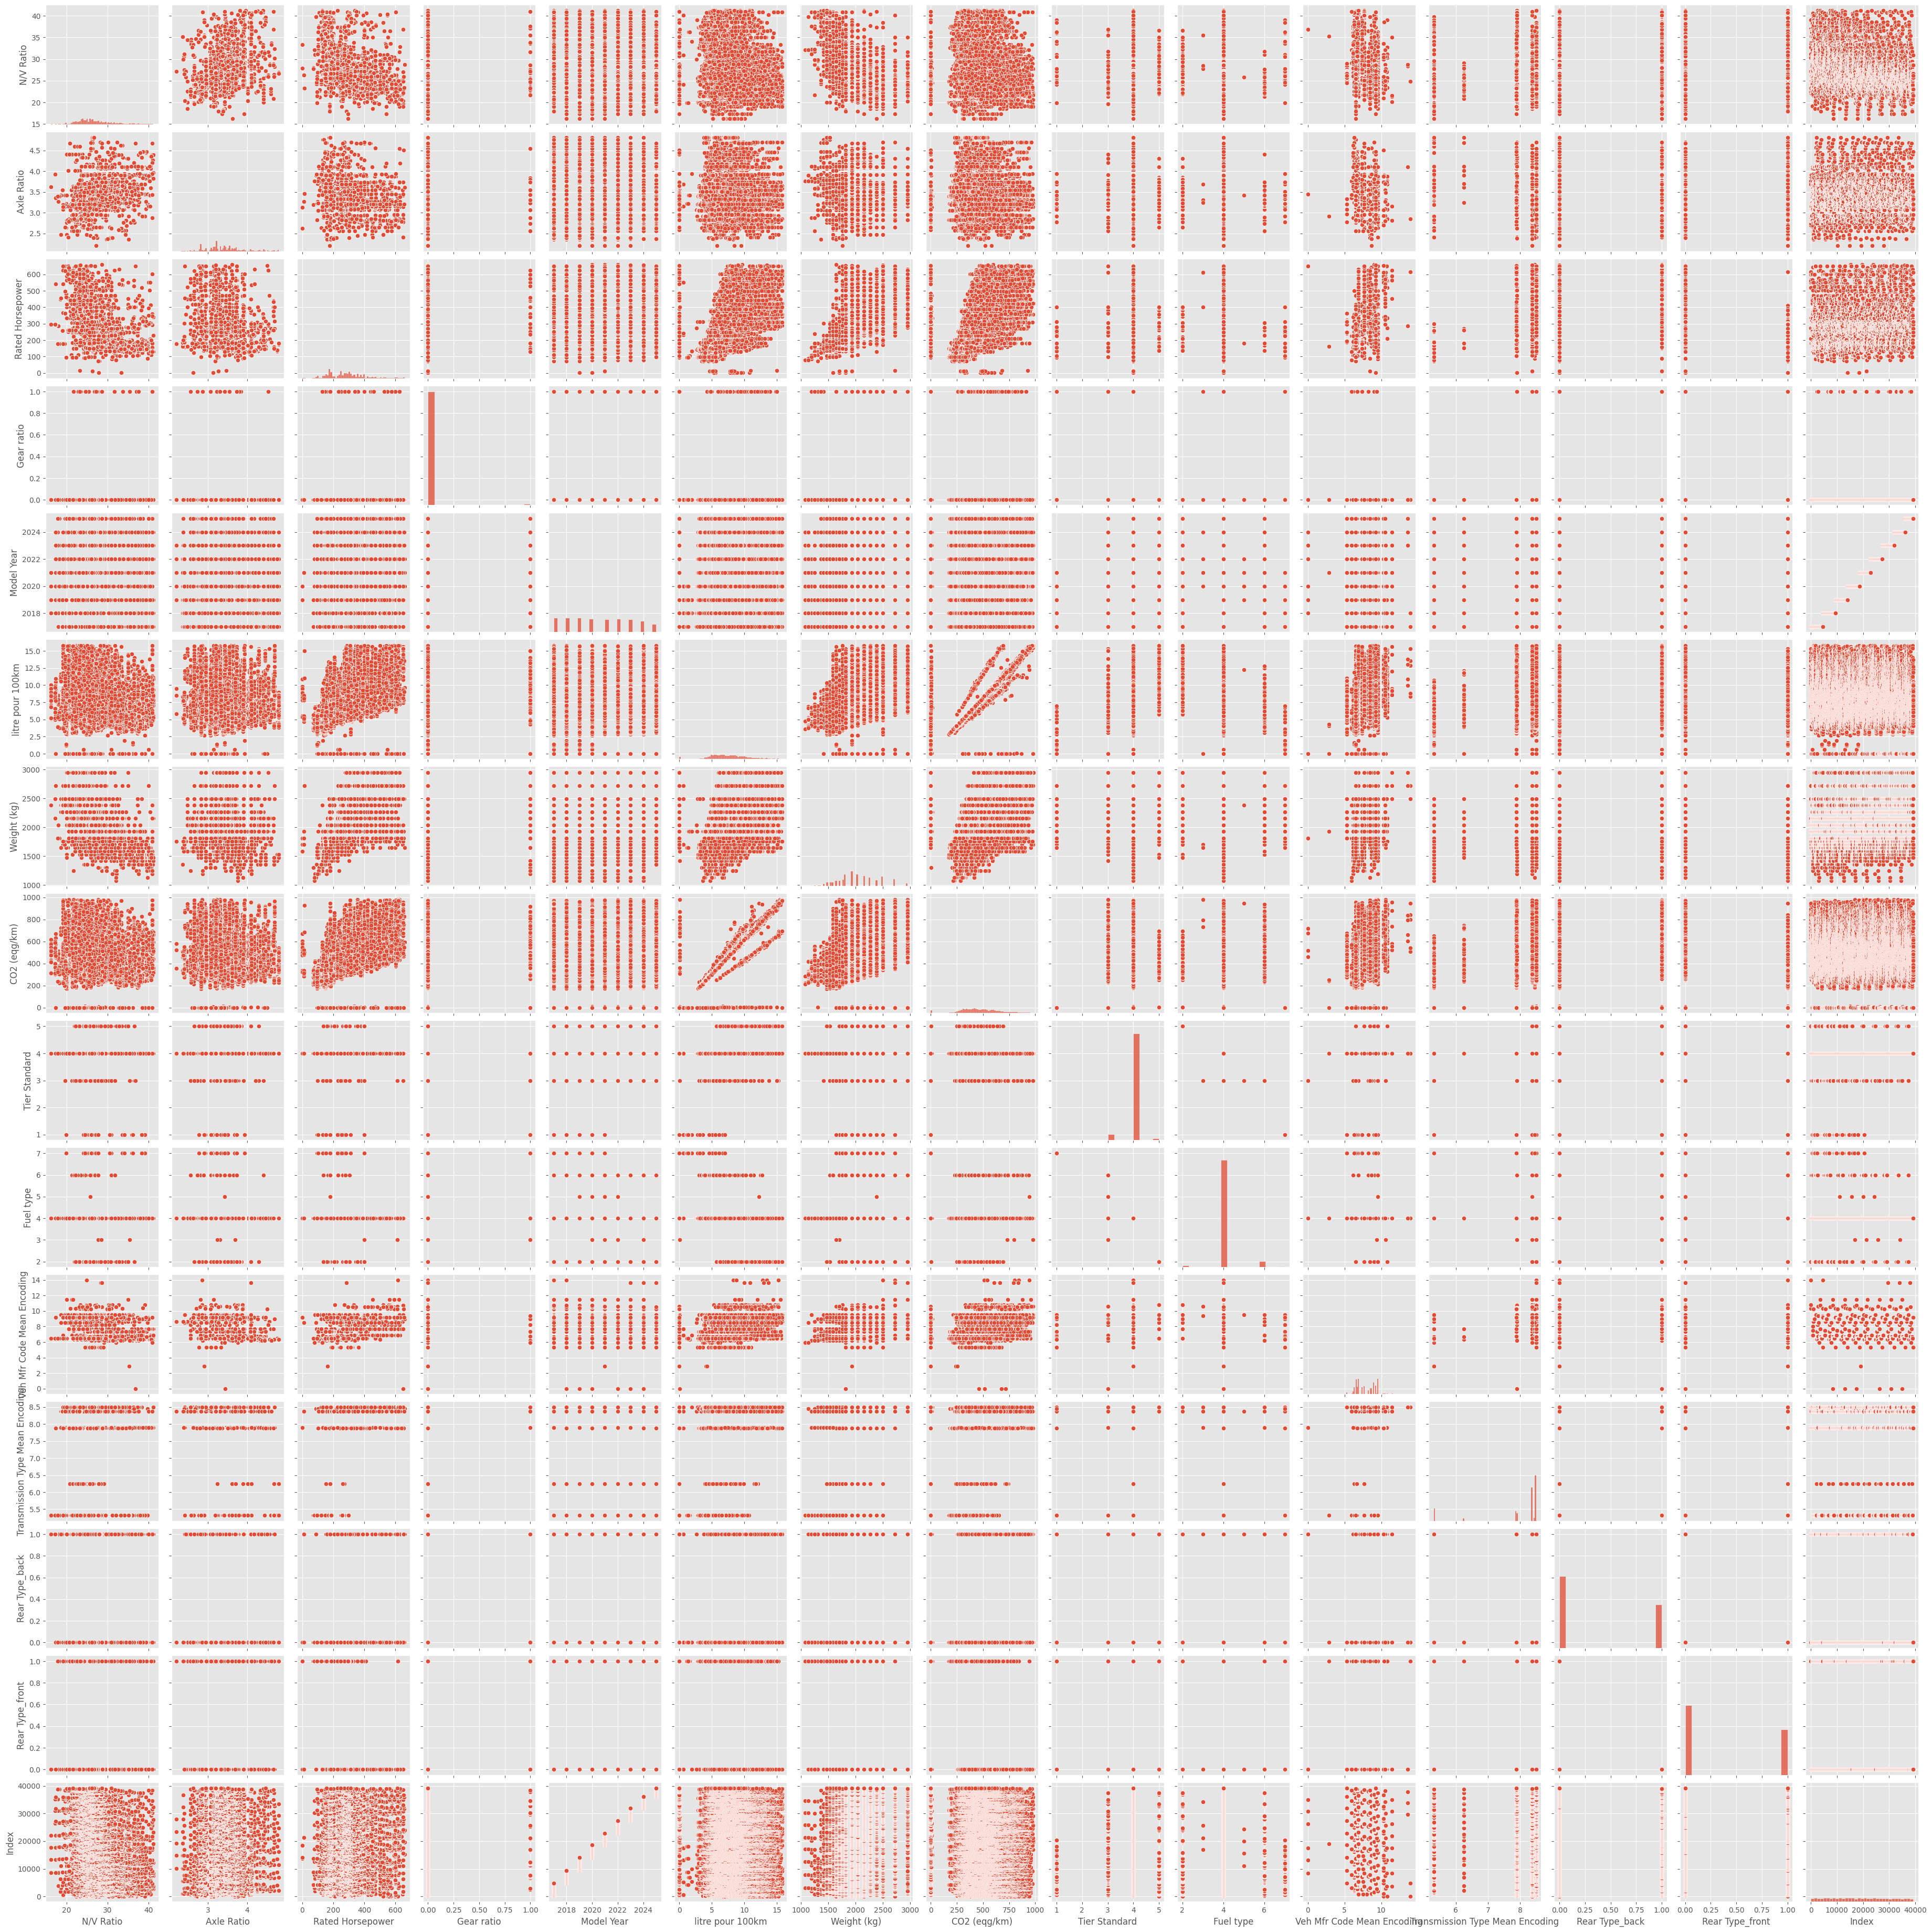

In [150]:
# distribution
sns.pairplot(df_vis,kind="scatter")

Les points que nous allons développer sont:
* répartition normal pour _N/V Ratio_, _Axel Ration_, _Rated Horse power_, _litre pour 100 km_, _Weight (kg)_, _CO2 (eq/km)_
* Une rapartition linéaire pour _CO2 (eq/km)_ en fonction de  _litre pour 100 km_

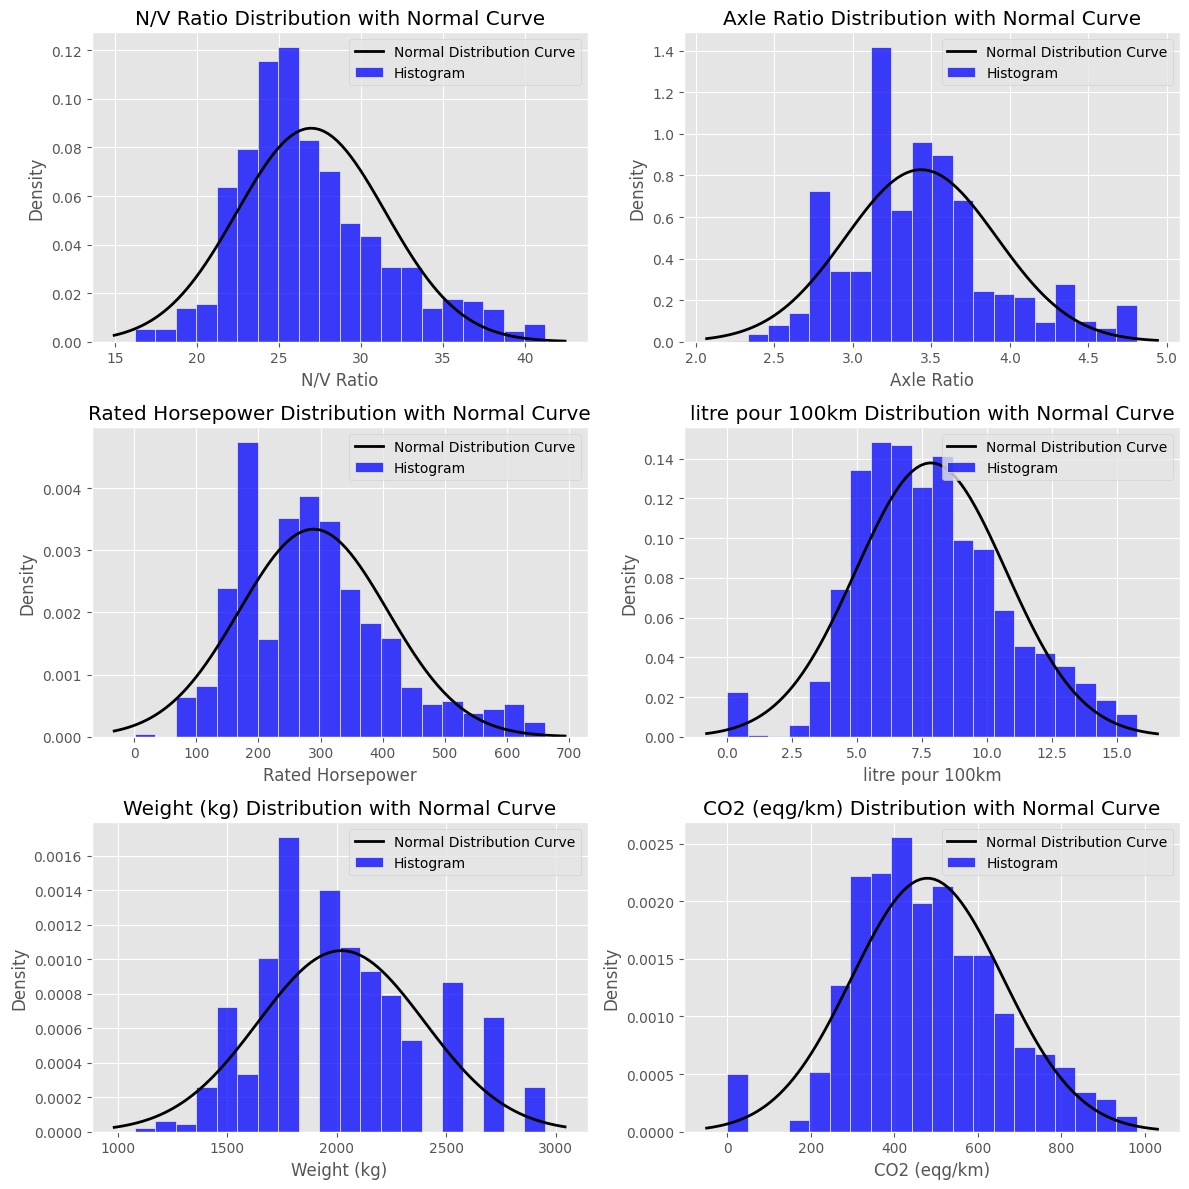

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# List of columns to plot
columns = ['N/V Ratio', 'Axle Ratio', 'Rated Horsepower', 'litre pour 100km', 'Weight (kg)', 'CO2 (eqg/km)']
# Set up the number of subplots
plt.figure(figsize=(12, 12))

# Loop over the columns
for i, column in enumerate(columns, 1):
    plt.subplot(3, 2, i)  # 3 rows, 2 columns subplot grid
    
    # Plot the histogram for the column
    sns.histplot(df_vis[column], kde=False, color='blue', bins=20, stat="density", label="Histogram")
    
    # Fit the normal distribution
    mu, std = norm.fit(df_vis[column].dropna())  # Fit the normal distribution
    
    # Plot the normal distribution curve
    xmin, xmax = plt.xlim()  # Get the current x-axis limits
    x = np.linspace(xmin, xmax, 100)  # Generate x values
    p = norm.pdf(x, mu, std)  # Compute the normal PDF
    plt.plot(x, p, 'k', linewidth=2, label="Normal Distribution Curve")
    
    # Set plot titles and labels
    plt.title(f"{column} Distribution with Normal Curve")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()


On remarque qu'il y a effectivement des répartions
 qui suivent une loi normal. Ceci nous conforte dans la propreté de nos données. A noter que comme la réapartition n'est pas uniforme, il sera important de résoudre ce problème pour avoir une bonne prédiction.

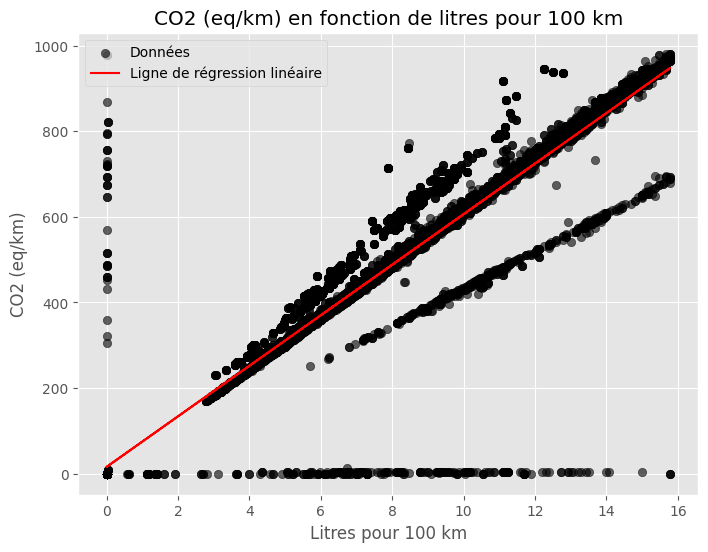

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Variables
X = df_vis['litre pour 100km'].values.reshape(-1, 1)  # Variable indépendante
y = df_vis['CO2 (eqg/km)'].values  # Variable dépendante

# Création du modèle de régression linéaire
model = LinearRegression()
model.fit(X, y)

# Prédictions sur la variable indépendante pour générer la ligne de régression
y_pred = model.predict(X)

# Tracer le nuage de points
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='black', label="Données", alpha=0.6)

# Tracer la ligne de régression
plt.plot(X, y_pred, color='red', label="Ligne de régression linéaire")

# Ajouter des labels et un titre
plt.xlabel("Litres pour 100 km")
plt.ylabel("CO2 (eq/km)")
plt.title("CO2 (eq/km) en fonction de litres pour 100 km")
plt.legend()

# Afficher le graphique
plt.show()


Une remarque une très forte corrélation, en accord avec ce que nous avions vu avec la matrice des corrélations et sur les graphiques des répartitions.

#### test de Pearson

__Explication__

Le test de Pearson (ou test du khi-deux de Pearson) est une méthode statistique permettant d'évaluer la relation entre deux variables qualitatives. Il compare les fréquences observées d'un échantillon aux fréquences attendues si les variables étaient indépendantes.

Il permet donc d'évaluer si des variables sont indépendantes. Plus le score sera élevé, plus elles seront indépendantes (un score inférieur à 0.05 indique une probable dépandences des variables). C'est pourquoi il devrait confirmer ce que nous avons remarqué plus tôt.

__Conditions d'utilisation__
1. Les deux variables sont quantitatives et mesurées sur une échelle continue 

On conserve donc 'litre pour 100km', 'Weight (kg)', 'CO2 (eqg/km)', 'N/V Ratio', 'Axle Ratio', 'Rated Horsepower'

2. La relation entre les deux variables est linéaire

3. Les deux variables suivent une **distribution normale**.

Au vu de la réaprtition on les conserves toutes. Mais il faut noté que l'étude sur la normalité se fera plus tard.

In [153]:
# Analyse de la normalité grâce au test de shapiro
from scipy.stats import pearsonr
pearson_colmuns = ['N/V Ratio', 'Axle Ratio', 'Rated Horsepower', 'litre pour 100km', 'Weight (kg)', 'CO2 (eqg/km)']
df_pearson = pd.DataFrame({col_name:{} for col_name in pearson_colmuns})

for col_a in pearson_colmuns:
    for col_b in pearson_colmuns:
        if col_a != col_b:
            corr, p_value = pearsonr(df_vis[col_a], df_vis[col_b])
            df_pearson.loc[col_a, col_b] = corr
df_pearson

N/V Ratio  Axle Ratio  Rated Horsepower  litre pour 100km  \
N/V Ratio               NaN       0.261            -0.292            -0.128   
Axle Ratio            0.261         NaN            -0.194            -0.004   
Rated Horsepower     -0.292      -0.194               NaN             0.518   
litre pour 100km     -0.128      -0.004             0.518               NaN   
Weight (kg)          -0.424      -0.070             0.556             0.451   
CO2 (eqg/km)         -0.131      -0.006             0.499             0.942   

                  Weight (kg)  CO2 (eqg/km)  
N/V Ratio              -0.424        -0.131  
Axle Ratio             -0.070        -0.006  
Rated Horsepower        0.556         0.499  
litre pour 100km        0.451         0.942  
Weight (kg)               NaN         0.436  
CO2 (eqg/km)            0.436           NaN

On obsere la encore les mêmes résultats

#### Test de Spearman

__Explication__

Le test de Spearman est une méthode statistique non paramétrique utilisée pour évaluer la force et la direction de l'association entre deux variables continues ou ordinales. Contrairement au coefficient de corrélation de Pearson, qui mesure la relation linéaire, le test de Spearman mesure la corrélation monotone, c'est-à-dire qu'il évalue si les variables augmentent ou diminuent ensemble, même si la relation n'est pas linéaire. Le résultat du test de Spearman est un coefficient de corrélation, souvent noté 
ρ
ρ (rho), qui varie entre -1 et 1, où -1 indique une corrélation négative parfaite, 1 indique une corrélation positive parfaite, et 0 indique l'absence de corrélation.

__Conditions d'utilisation__
1. Les deux variables sont quantitatives ou **ordinales**.

2. Les données n'ont pas besoin d'être normalement distribuées.

C'est pourquoi on peut tester avec 'Model-year' cette fois-ci.

3. La relation entre les variables peut être monotone (linéaire ou non linéaire).

numer

In [154]:
# Analyse de la normalité grâce au test de shapiro
from scipy.stats import spearmanr
spearman_colmuns = numerical_columns.copy()
df_spearman_score = pd.DataFrame({col_name:{} for col_name in spearman_colmuns})
df_spearman_p_value = pd.DataFrame({col_name:{} for col_name in spearman_colmuns})

for col_a in spearman_colmuns:
    for col_b in spearman_colmuns:
        if col_a != col_b:
            res = spearmanr(df_vis[col_a], df_vis[col_b])
            corr = res.correlation
            p_value = res.pvalue
            df_spearman_score.loc[col_a, col_b] = corr
            df_spearman_p_value.loc[col_a, col_b] = p_value
print("spearmanr correlation")
df_spearman_score
print("spearmanr p_value")
df_spearman_p_value

spearmanr correlation
spearmanr p_value


N/V Ratio  Axle Ratio  Rated Horsepower  Model Year  \
N/V Ratio               NaN       0.000             0.000       0.000   
Axle Ratio            0.000         NaN             0.000       0.000   
Rated Horsepower      0.000       0.000               NaN       0.000   
Model Year            0.000       0.000             0.000         NaN   
litre pour 100km      0.000       0.026             0.000       0.010   
Weight (kg)           0.000       0.000             0.000       0.000   
CO2 (eqg/km)          0.000       0.254             0.000       0.000   

                  litre pour 100km  Weight (kg)  CO2 (eqg/km)  
N/V Ratio                    0.000        0.000         0.000  
Axle Ratio                   0.026        0.000         0.254  
Rated Horsepower             0.000        0.000         0.000  
Model Year                   0.010        0.000         0.000  
litre pour 100km               NaN        0.000         0.000  
Weight (kg)                  0.000          NaN         0.000  
CO2 (eqg/km)                 0.000        0.000           NaN

Sans surprise on observe une faible voir pas de corrélation

#### Analyse des corrélations avec colonnes catégorielles

L'analyse de fait comme expliqué ci-dessous

In [157]:
# with this two column, we can better understand what would be the result for a correlated column and an uncorrelated column
#df_vis["witness Veh Mfr Code"] = df_vis["Veh Mfr Code"]
#df_vis["uniform distribution"] = np.random.choice(["a","b","c","d"], size=df_vis.shape[0])
#df_vis["uniform distribution b"] = df_vis["uniform distribution"]

#replacement_probabilities = {
#    "a": 0.5,  # 50% chance to replace "a" with "e"
#    "b": 0.5,  # 50% chance to replace "b" with "f"
#    "c": 0.5,  # 50% chance to replace "c" with "g"
#    "d": 0.5   # 50% chance to replace "d" with "h"
#}
#replacements = {
#    "a": "e",
#    "b": "f",
#    "c": "g",
#    "d": "h"
#}
## Create the new column with random replacements
#df_vis["modified uniform distribution"] = df_vis["uniform distribution"].apply(
#    lambda x: np.random.choice([x, replacements[x]], p=[1 - replacement_probabilities[x], replacement_probabilities[x]])
#)


#normal_values = np.random.normal(loc=0, scale=1, size=df_vis.shape[0])
#thresholds = [-1, 0, 1]
#categories = ["a", "b", "c", "d"]
#df_vis["normal distribution"] = pd.cut(normal_values, bins=[-np.inf, *thresholds, np.inf], labels=categories)


#categrocial_columns = df_vis.select_dtypes(exclude=[np.number]).columns
#categrocial_columns

notre idée (comme détaillé ci-dessous) et de calculer la probabilité d'une varaible, puis de la même varaible mais sachant qu'une de ces valeurs et celle de l'autre (on compare P(A|B) à P(A)). On identifie ensuite si les variables sont bien indépendantes. Notamment plus les probabilités de  P(A|B) sont différentes deP(A), plus elles sont dépendantes.

In [158]:
# obtention des probabilités
#def categorical_correlation_study(df, column_a, column_b):
#    def probs(values):
#        probs_res = {}
#        for v, ct in values.items():
#            probs_res[v] = ct/df.shape[0]
#        return probs_res
#
#    # les probabilités
#    pk2_dic = probs(df[column_b].value_counts())
#    pk1_dic = probs(df[column_a].value_counts())
#    pk2_k1_dic = {}
#    for k1 in pk1_dic.keys():
#        for k2 in set(df[column_b]):
#            pk1_k2 = len(df[(df[column_a]==k1) & (df[column_b]==k2)])/len(df[df[column_a]==k1])
#            pk2_k1_dic[(k1, k2)] = pk1_k2
#    # on print une heatmap des probabilités
#    df_pk1_k2 = pd.DataFrame(list(pk2_k1_dic.items()), columns=['Combination', 'pk2|pk1'])
#    df_pk1_k2["pk2 alone"] = df_pk1_k2["Combination"].apply(lambda x: pk2_dic[x[1]])
#    df_pk1_k2["pk1 alone"] = df_pk1_k2["Combination"].apply(lambda x: pk1_dic[x[0]])
#
#    df_pk1_k2["diff"]= abs(df_pk1_k2["pk2|pk1"]-df_pk1_k2["pk2 alone"])
#
#    df_pk1_k2_plot = df_pk1_k2.set_index("Combination")[["diff", "pk2|pk1", "pk2 alone"]]
#
#    #plt.figure(figsize=(4, len(df_pk1_k2_plot) * 0.5))  # Adjust height based on number of rows
#    #sns.heatmap(df_pk1_k2_plot, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5, cbar=True, vmax=1, vmin=0)
#
#    ## Customize labels
#    #plt.title(f"Independance {column_a} and {column_b}")
#    #plt.xlabel("Difference Value")
#    #plt.ylabel("Combination")
#
#    #plt.show()
#    score = df_pk1_k2["diff"].mean()
#    return score
#
#scores_dependancy_catargorial = pd.DataFrame({"col a": [], "col b": [], "score": []})
#for col_a in categrocial_columns:
#    for col_b in categrocial_columns:
#        if col_a != col_b:
#            scores_dependancy_catargorial.loc[len(scores_dependancy_catargorial)] = [col_a, col_b, categorical_correlation_study(df_vis, col_a, col_b)]
#scores_dependancy_catargorial


Ici on a observé qu'elles sont très dépendantes (puisque ce sont les mêmes distribution!)

### Analyse de la normalité

#### Plot des densités et répartition

N/V Ratio


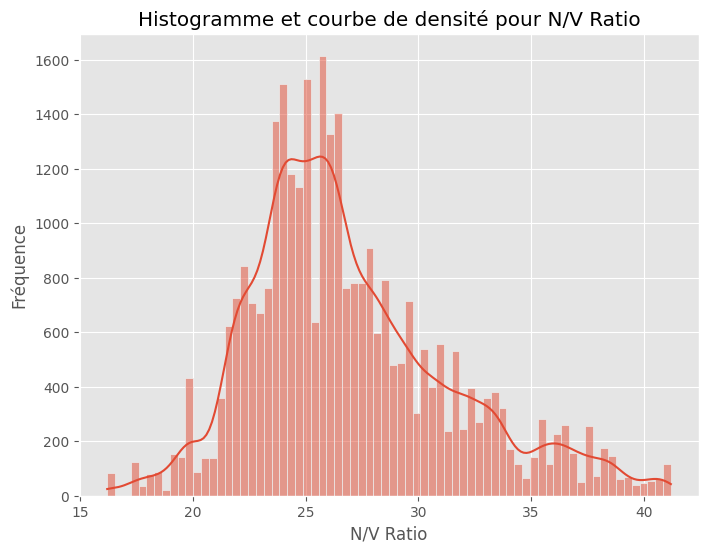

Axle Ratio


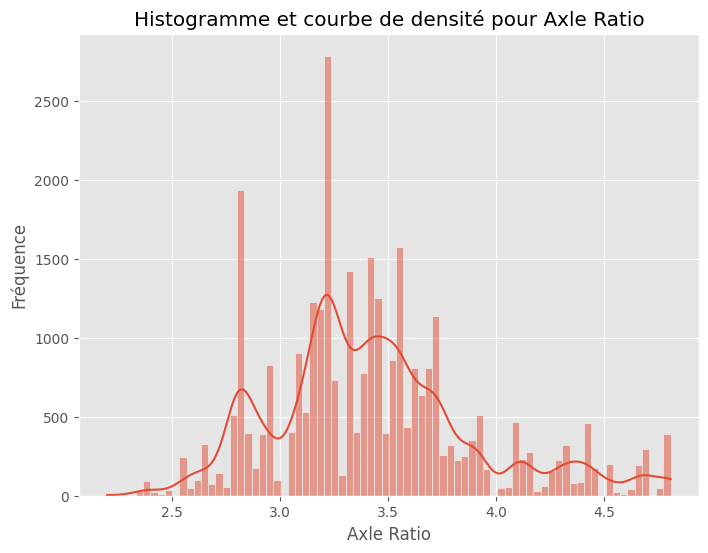

Rated Horsepower


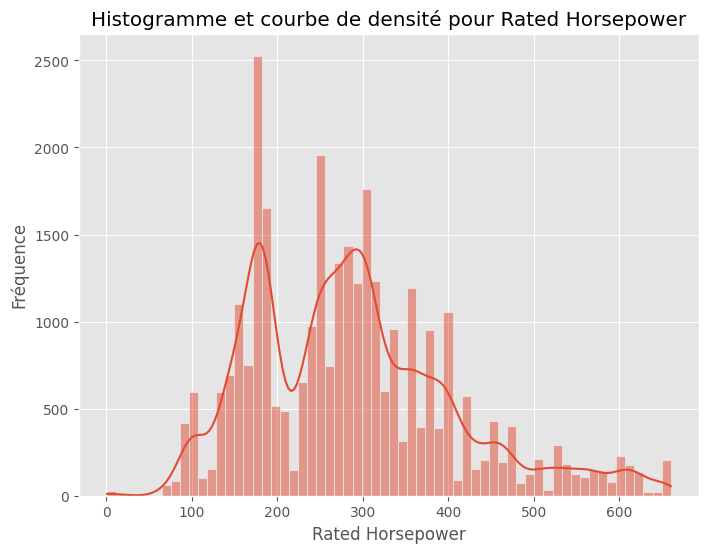

Gear ratio


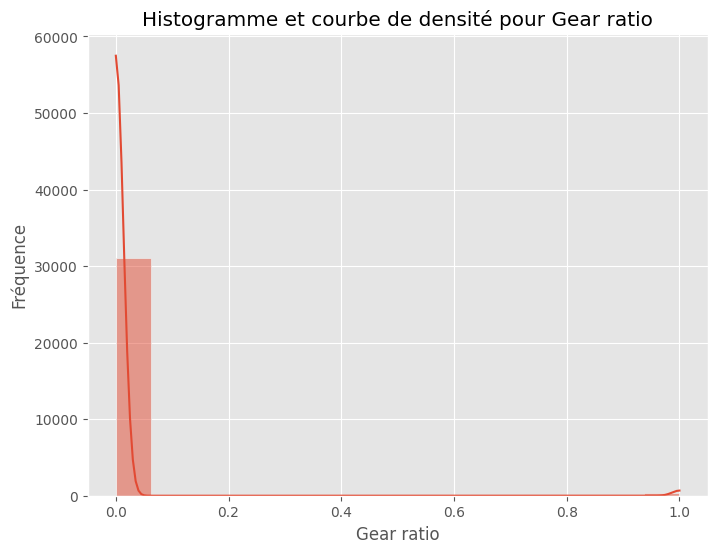

Model Year


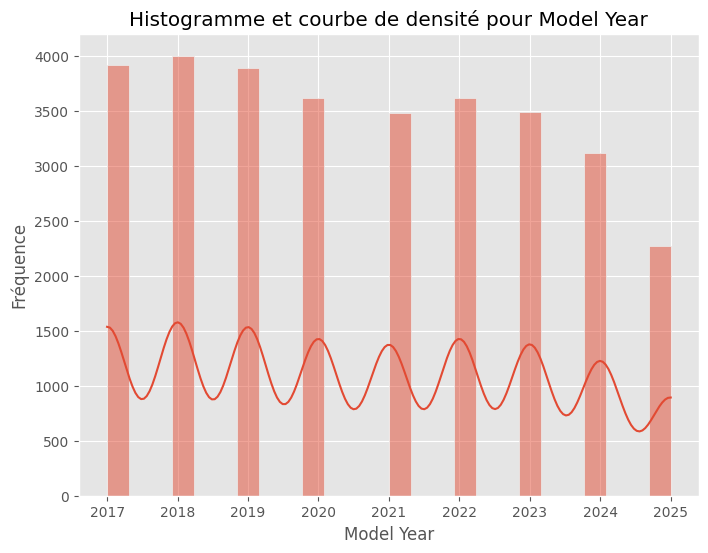

litre pour 100km


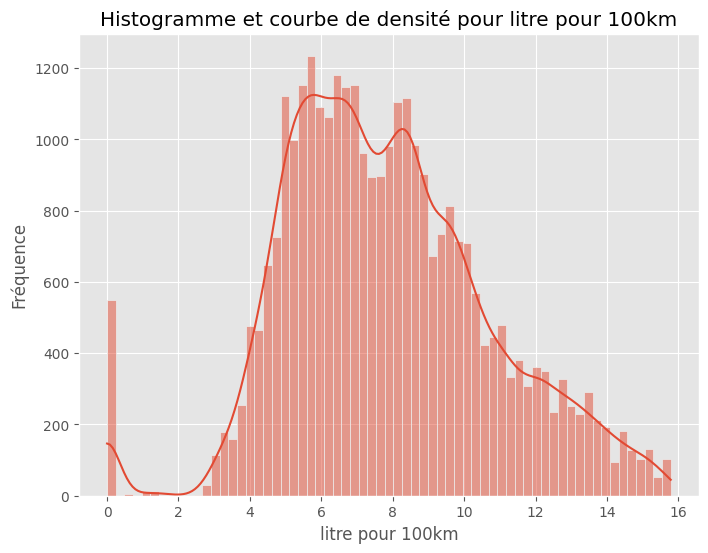

Weight (kg)


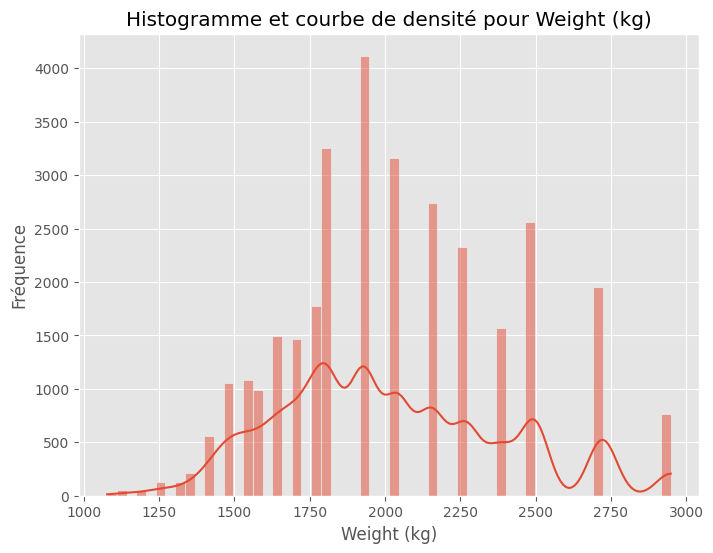

CO2 (eqg/km)


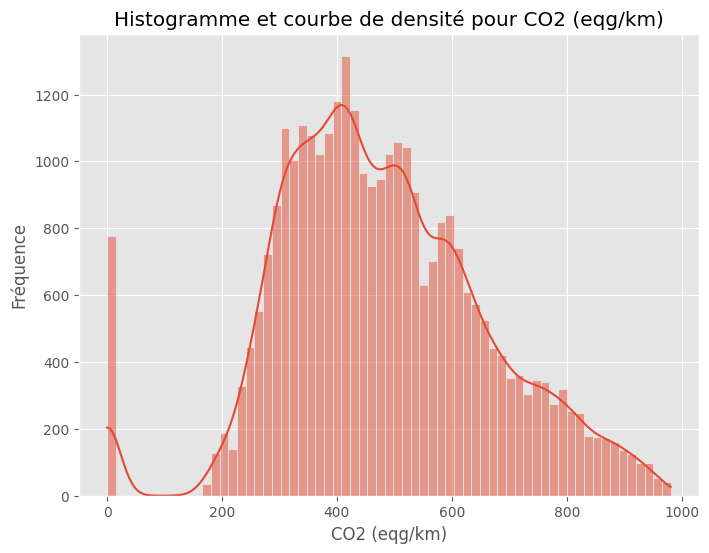

Tier Standard


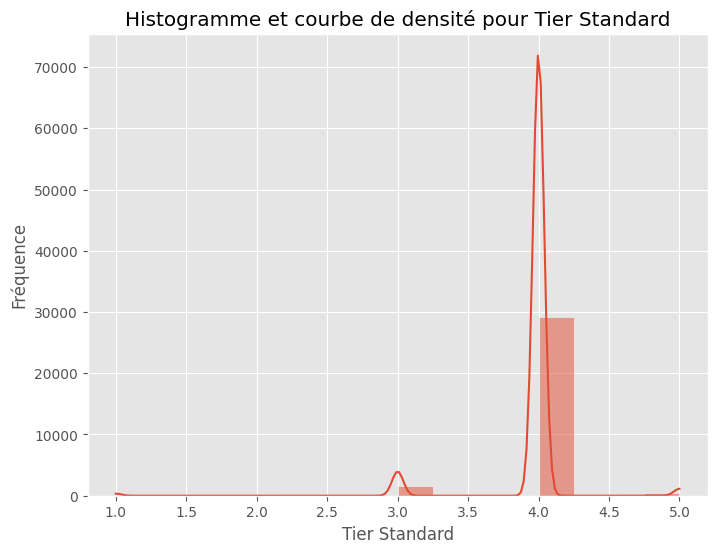

Fuel type


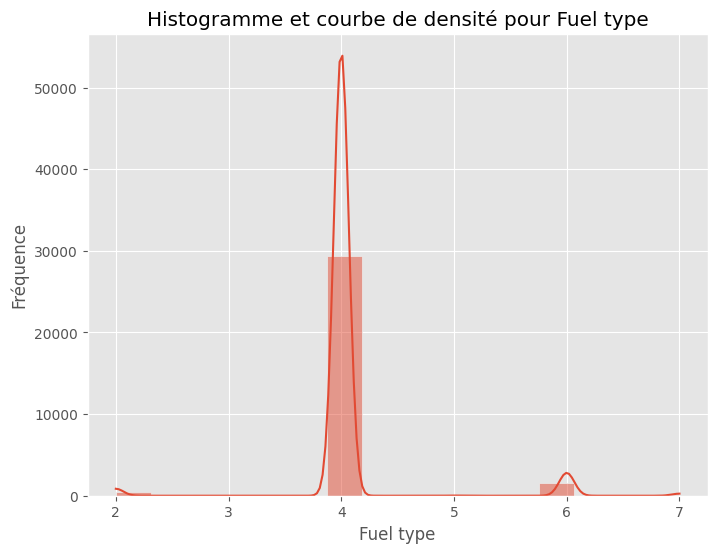

Veh Mfr Code Mean Encoding


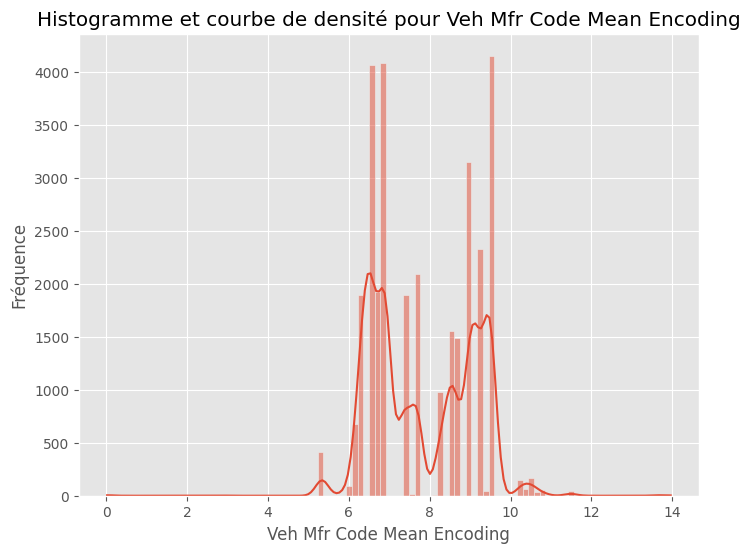

Transmission Type Mean Encoding


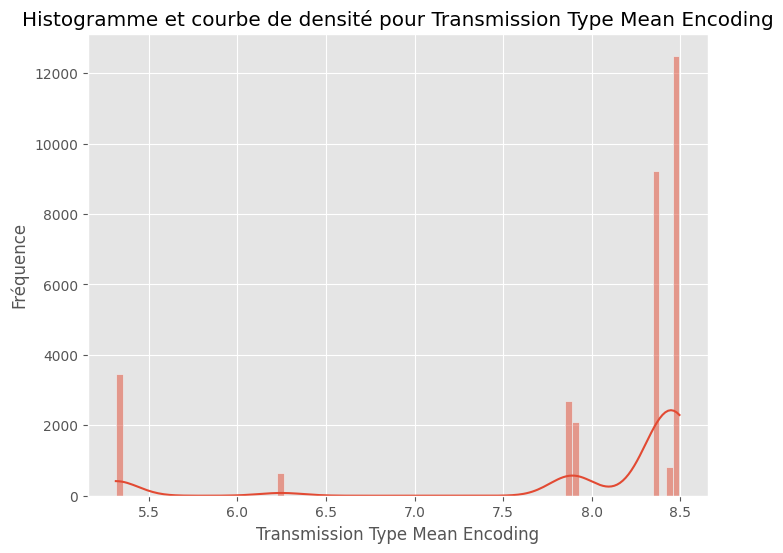

Rear Type_back


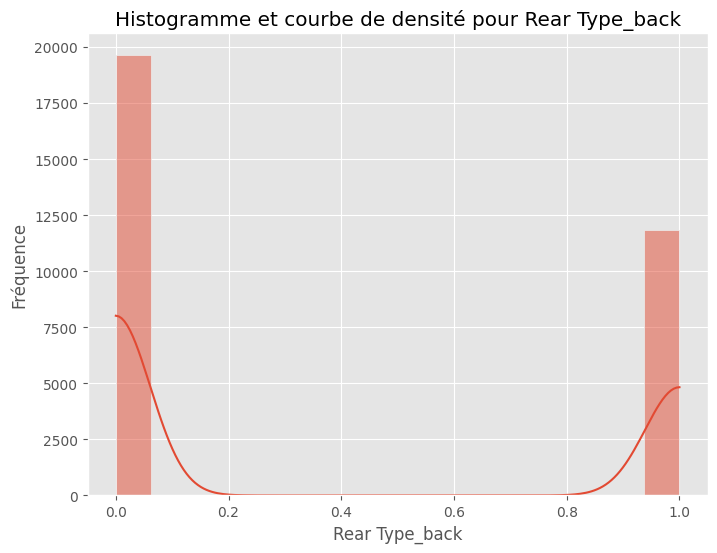

Rear Type_front


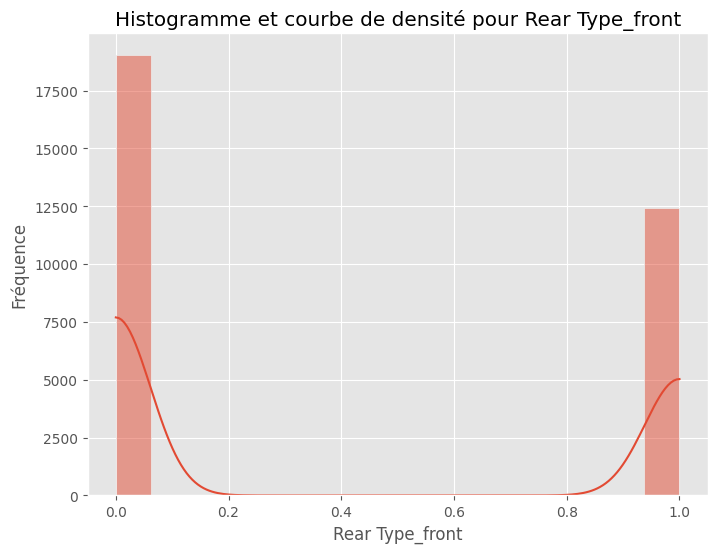

Index


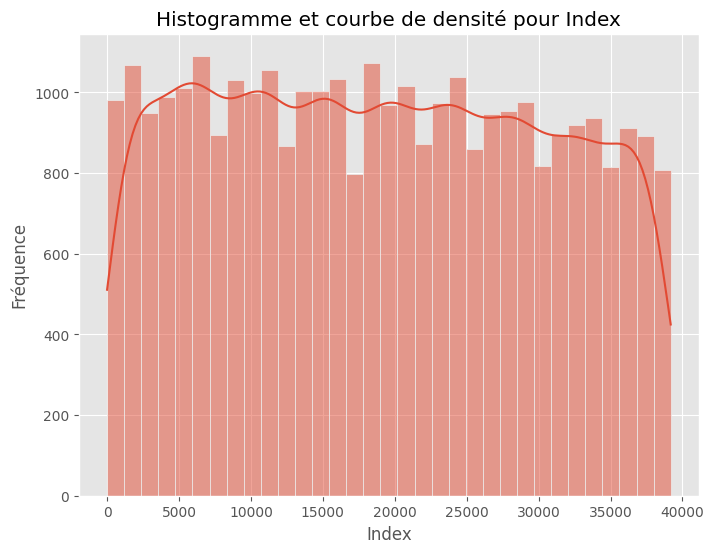

In [159]:
# Analyse graphique de la normalité des variables
for var in df_vis.columns:
    print(var)
    plt.figure(figsize=(8, 6))
    sns.histplot(df_vis[var], kde=True)
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    plt.title(f"Histogramme et courbe de densité pour {var}")
    plt.show()

On remarque une distribution normal pour:
* CO2 (eqg/km)
* Weight (kg)
* litre pour 100km
* Rated Horsepower
* Axle Ratio
* N/V Ratio
Nous allons la confirmer avec des QQplot.

In [193]:
df4.columns

Index(['N/V Ratio', 'Axle Ratio', 'Rated Horsepower', 'Veh Mfr Code',
       'Transmission Type', 'Gear ratio', 'Model Year', 'litre pour 100km',
       'Weight (kg)', 'CO2 (eqg/km)', 'Tier Standard', 'Fuel type',
       'Rear Type'],
      dtype='object')

#### QQplot

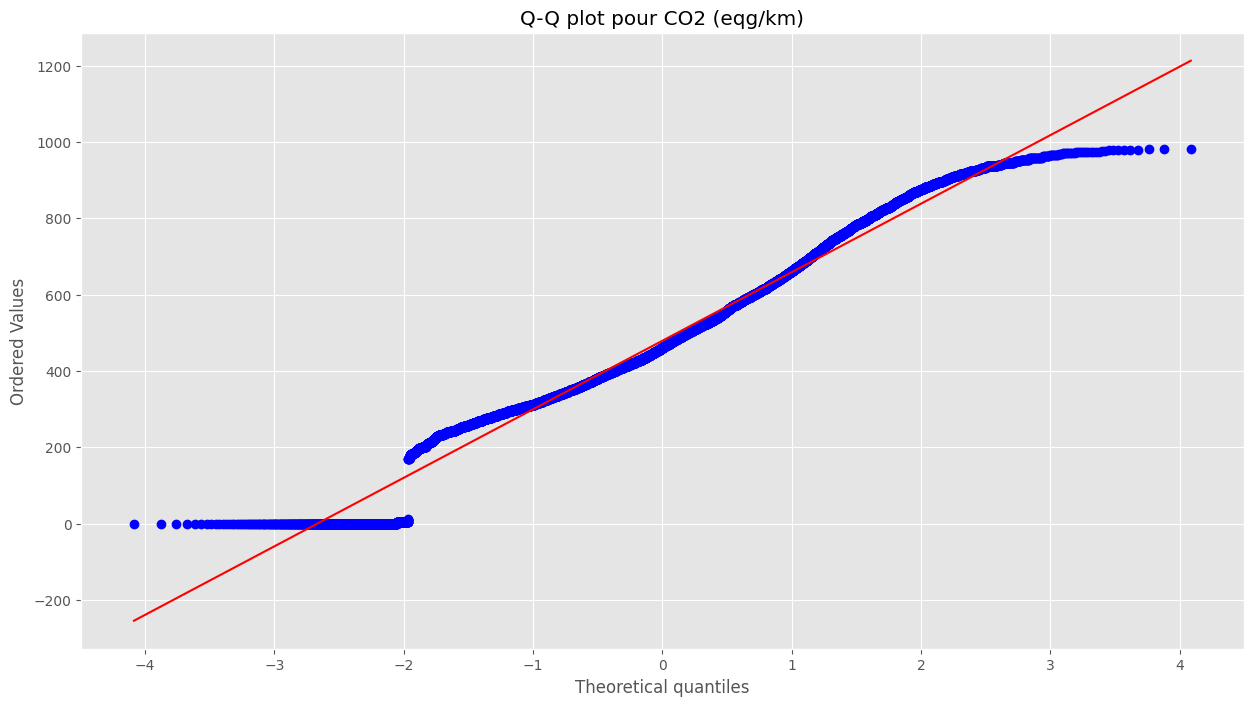

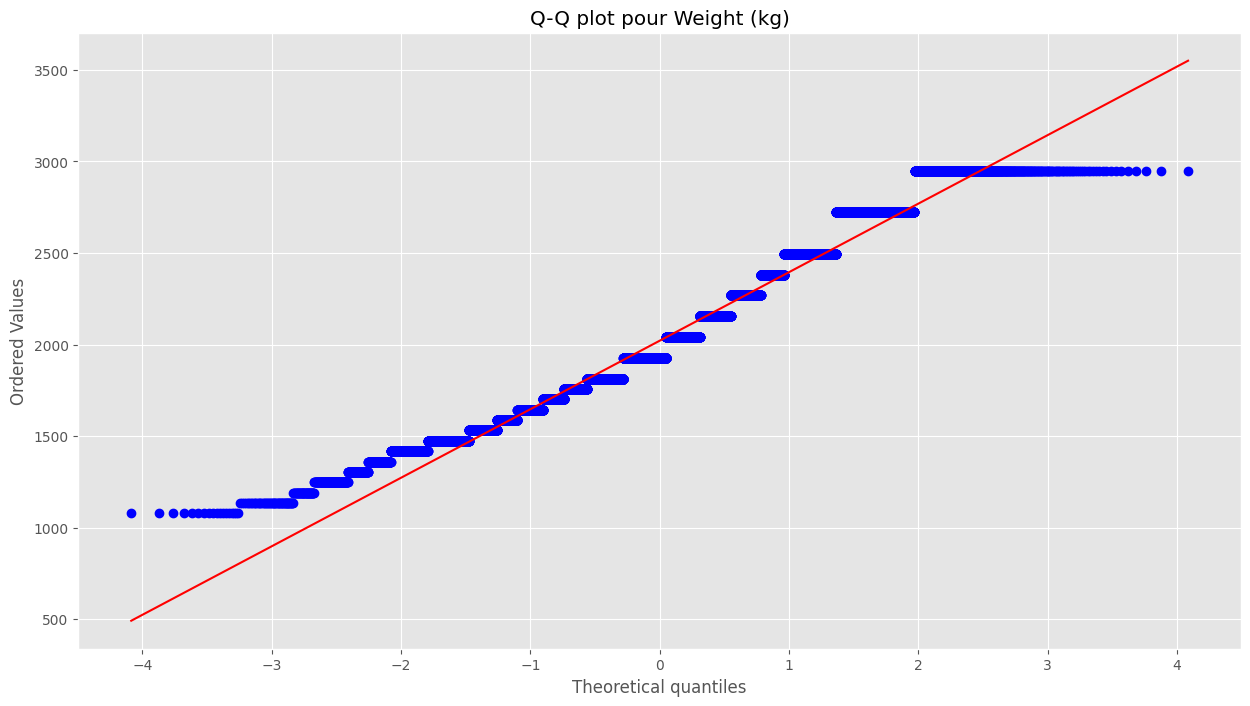

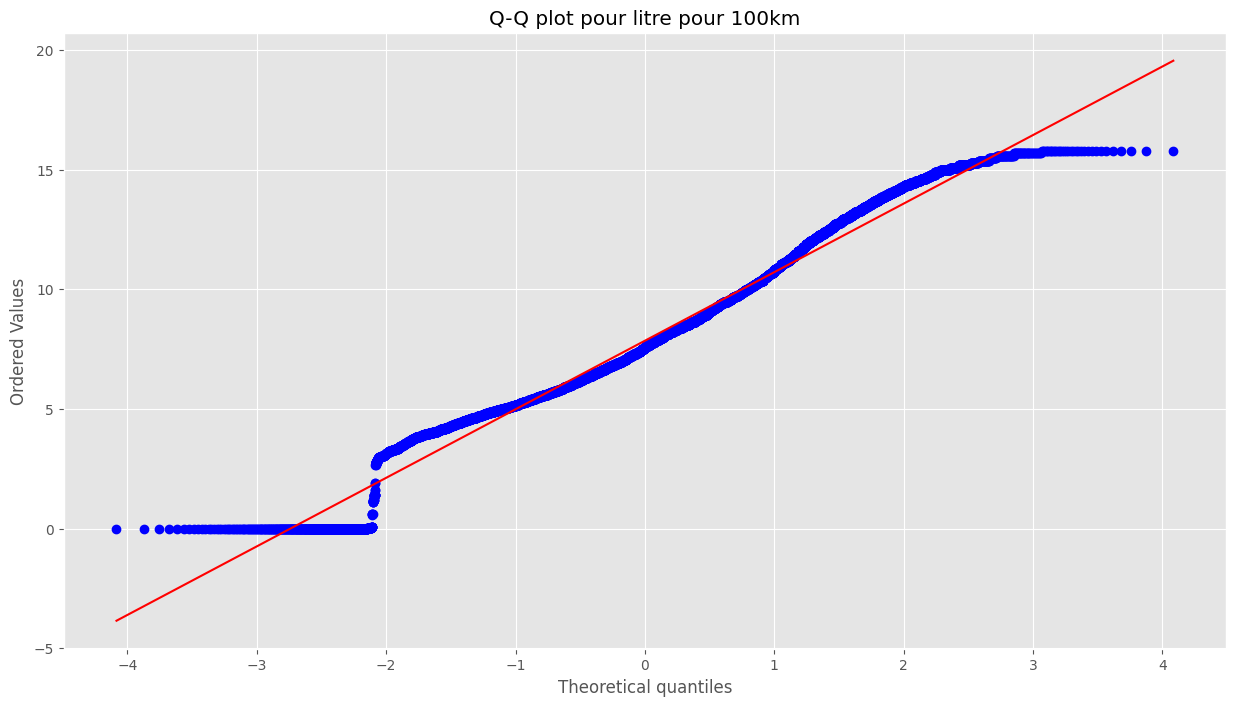

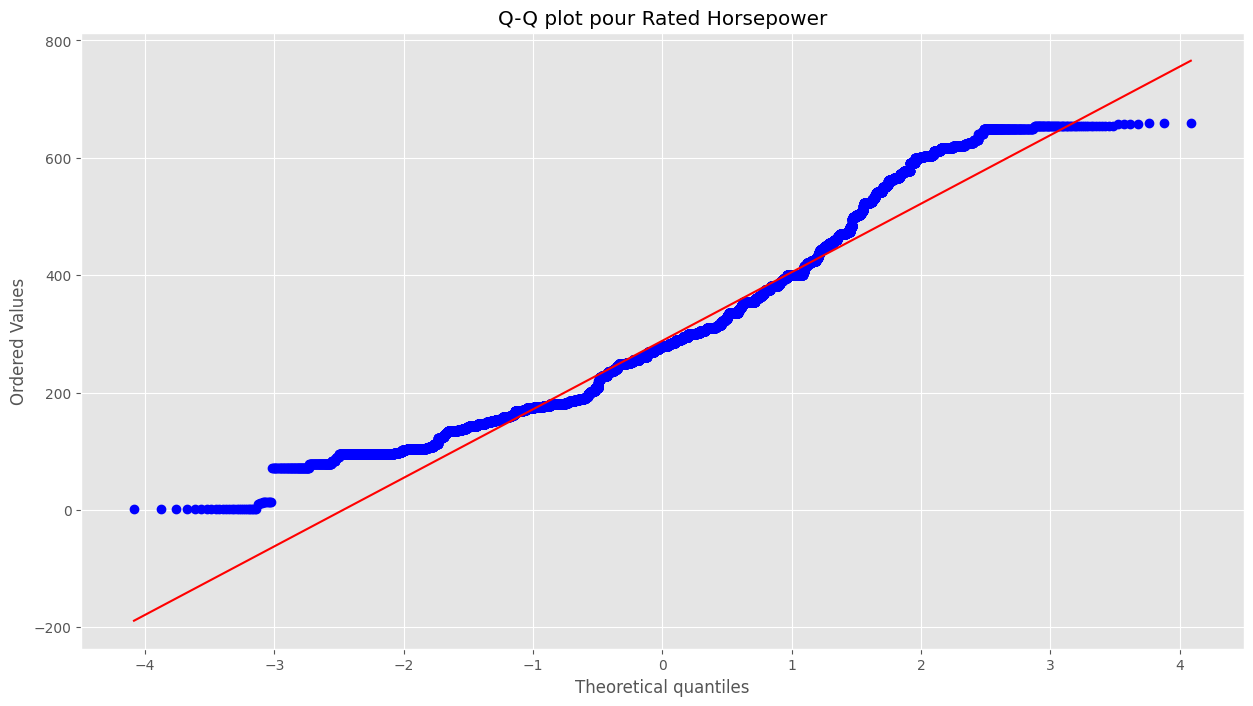

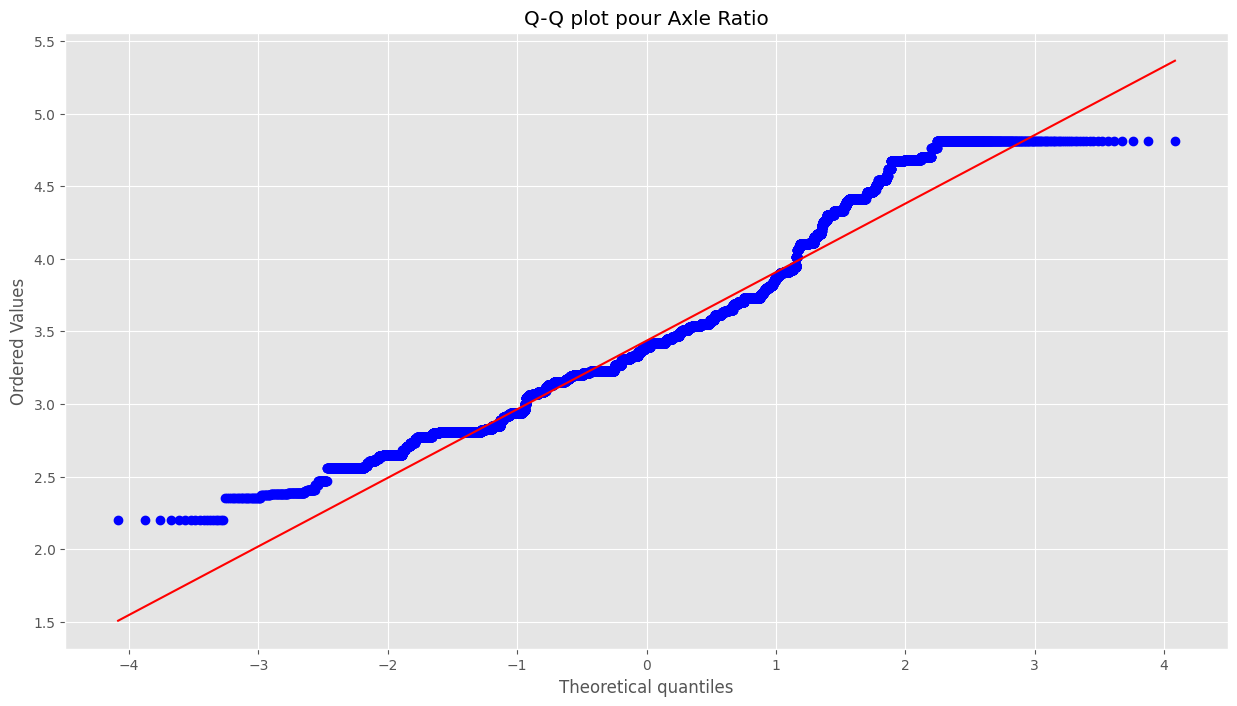

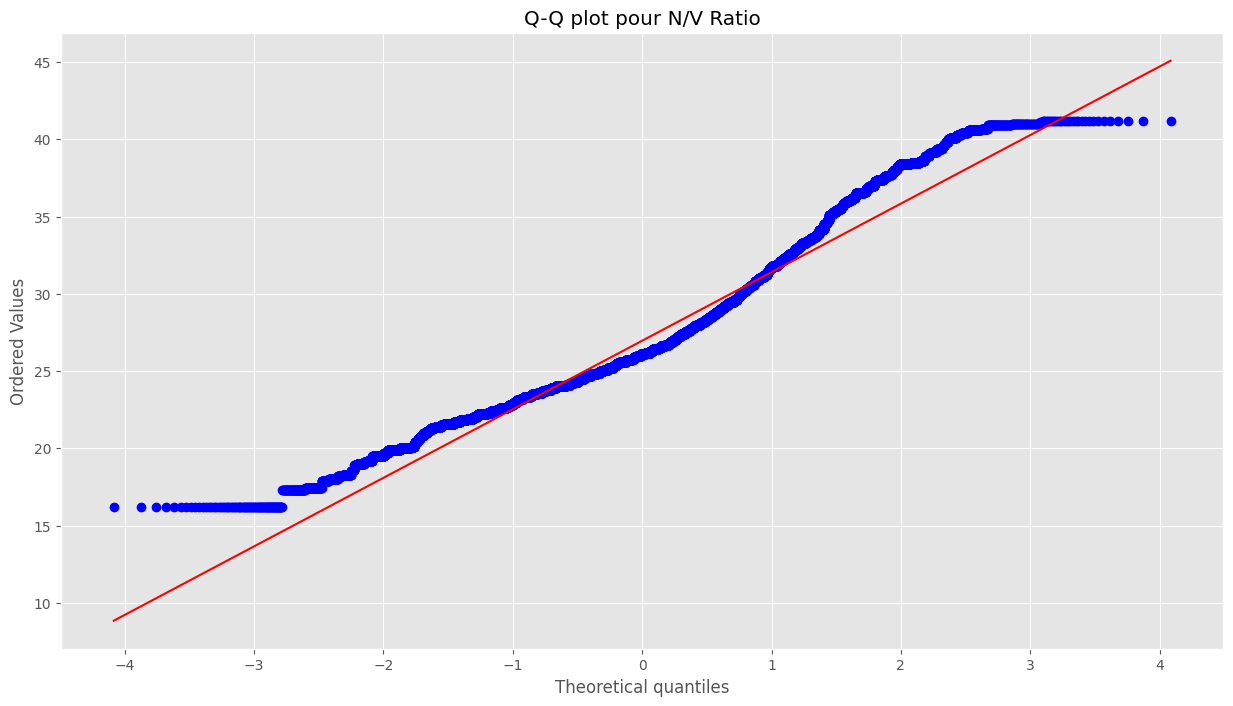

In [160]:
columns_normality = ['CO2 (eqg/km)', 'Weight (kg)', 'litre pour 100km', 'Rated Horsepower', 'Axle Ratio', 'N/V Ratio']
for el in columns_normality:
    plt.figure()
    stats.probplot(df_vis[el], plot=plt)
    plt.title(f'Q-Q plot pour {el}')
    plt.show()

this probplot conforts us to think that indeed they are normal distribution.

#### test de Shapiro
* notre échantillon est de petite taille
* pour les petits échantillons il permet les meilleurs résultats

In [161]:
seuil = 0.05
# create a dataframe to store the results
df_shapiro = pd.DataFrame({"columns": [], "score": [], "p-valeur": [], "normalité": []})
for column in columns_normality:
    shapiro_test = stats.shapiro(df_vis[column])
    score = shapiro_test[0]
    pvaleur = shapiro_test[1]
    noramlite = 'Oui' if shapiro_test[1] > seuil else 'Non'
    # append new line to dataframe    
    df_shapiro = df_shapiro.append({"columns": column, "score": score, "p-valeur": pvaleur, "normalité": noramlite}, ignore_index=True)
    
print("Réalisation du test de chapirro pour chaque colonne")
df_shapiro

Réalisation du test de chapirro pour chaque colonne


c:\Users\marcl\OneDrive\Bureau\ML\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 31446.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\marcl\AppData\Local\Temp\ipykernel_33936\3390461444.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_shapiro = df_shapiro.append({"columns": column, "score": score, "p-valeur": pvaleur, "normalité": noramlite}, ignore_index=True)
c:\Users\marcl\OneDrive\Bureau\ML\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 31446.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\marcl\AppData\Local\Temp\ipykernel_33936\3390461444.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

columns  score  p-valeur normalité
0      CO2 (eqg/km)  0.981     0.000       Non
1       Weight (kg)  0.971     0.000       Non
2  litre pour 100km  0.980     0.000       Non
3  Rated Horsepower  0.955     0.000       Non
4        Axle Ratio  0.959     0.000       Non
5         N/V Ratio  0.956     0.000       Non

au regard des tests il ne semble pas avoir de normalité très marquée. Cela nous surprends beaucoup.

## Training Machine Learning Models


### X et y

In [162]:
X = df_vis.drop(columns=["CO2 (eqg/km)"])
y = df_vis["CO2 (eqg/km)"]

### Configure

##### Non nécessaire

* nous avons suffisament de données (vu précédemment) aucune étape de génération de données (synthetic data generation) n'est nécessaire
* les problèmes de corrélations ont été gérés


##### Normalisation

Elle permet de résoudre les différences d'échelles (feature scaling). Elle ne se fait que sur les colonnes d'entrée (et pas sur la colonne de prédiction) car nous voulons en sortie avoir un résultat utiliseable.

Nous utilisons le Min Max Scaler car il garde la différence de répartition des données (au contraire du Standard Scaler). Ainsi une distribution d'origine linéaire restera linéaire après le min max scaler, alors que le Standard Scaler la normalisera (nos données n'étant pas toute normale).

In [172]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normaliser les données
X_min_max_normalized = scaler.fit_transform(X)
X_standardized_normalized = StandardScaler().fit_transform(X)

##### équilibrage des classes

### Split

#### En division simple

On choisi la division train-dev-test. C'est une méthode couramment utilisée en apprentissage automatique pour évaluer la performance d'un modèle. Elle consiste à diviser les données en trois ensembles distincts : l'ensemble d'entraînement (train), l'ensemble de développement (dev) et l'ensemble de test (test). L'ensemble d'entraînement est utilisé pour entraîner le modèle, l'ensemble de développement pour ajuster les hyperparamètres et effectuer des validations intermédiaires, et l'ensemble de test pour évaluer la performance finale du modèle sur des données non vues et pouvoir le comparer avec d'autres modèles.

Une proportion courante de division est 70-15-15. Cela signifie que 70% des données sont utilisées pour l'entraînement, 15% pour le développement et 15% pour le test. Cette répartition permet d'avoir suffisamment de données pour entraîner le modèle tout en réservant une partie significative pour l'évaluation et l'ajustement des hyperparamètres, assurant ainsi une évaluation robuste de la performance du modèle.

In [166]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train_simple, X_temp, y_train_simple, y_temp = train_test_split(X_min_max_normalized, y, test_size=0.3, random_state=42, shuffle=True, stratify=None)

# Diviser l'ensemble temporaire en ensembles de développement et de test
X_dev_simple, X_test_simple, y_dev_simple, y_test_simple = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Puis on vérifie que nos échantillons sont bien répartie en réalisant un test anova. Si la p-valeur est supérieur au seuil on rejette l'hypothèse null: nos échantillons sont distribués différement.

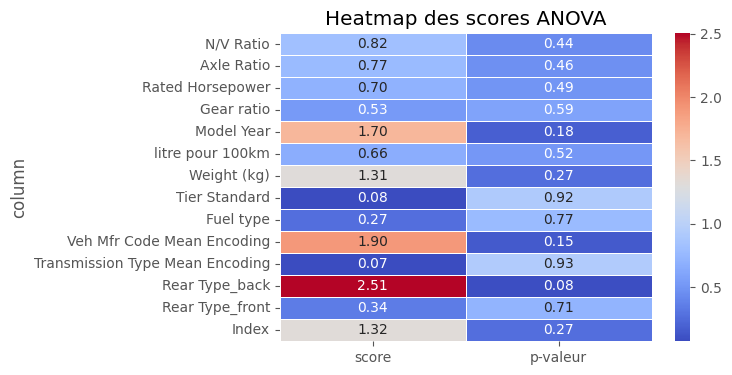

In [187]:
# TODO implémenter correctement ANOVA et faire une bonne étude de corrélation sur les variables catégorielles.
# TODO voir ce qu'il faut faire (en terme de choix d'échantillon avec des variable catégorielles)

import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

df_anova_score = pd.DataFrame({"column": [], "score": [], "p-valeur": []})


# Fonction pour effectuer l'ANOVA et visualiser les résultats
def analyze_correlation(col):
    # Effectuer l'ANOVA
    anova_result = stats.f_oneway(
        list([x[col] for x in X_train_simple]), 
        list([x[col] for x in X_dev_simple]), 
        list([x[col] for x in X_test_simple])
    )

    return anova_result.statistic, anova_result.pvalue

# Analyser chaque combinaison de colonnes catégorielles et numériques
# non numerical columns
for col_index, col_name in enumerate(X.columns):
    score, pvalue = analyze_correlation(col_index)
    df_anova_score.loc[len(df_anova_score)] = [col_name, score, pvalue]



# Création de la heatmap avec seaborn
plt.figure(figsize=(6, 4))  # Ajuster la taille
sns.heatmap(df_anova_score.set_index("column"), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Affichage du graphique
plt.title("Heatmap des scores ANOVA")
plt.show()


Ici on observe que H0: "les groupes ont la même population", est validé pour un alpha=0.08. Donc avec confiance on continue la démarche.

#### En validation croisée

La validation croisée est une technique plus robuste qui divise les données en plusieurs sous-ensembles (ou "folds"). Le modèle est entraîné et validé sur différentes combinaisons de ces folds. Le détail des scores avec la validation croisée seront vus plus tard (car ils demandent d'avoir déjà les modèles)

### Test models

### Model Comparison

#### Random forest regressor

In [191]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Définition du modèle Random Forest
rf = RandomForestRegressor(random_state=42)

# Définition des hyperparamètres pour Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],   # Nombre d'arbres
    'max_depth': [None, 10, 20],      # Profondeur max
    'min_samples_split': [2, 5, 10],  # Nombre min d'échantillons pour splitter un nœud
    'min_samples_leaf': [1, 2, 4]     # Nombre min d'échantillons par feuille
}

# Grid Search avec validation croisée (3-fold)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_simple, y_train_simple)

# Meilleurs hyperparamètres
print("Meilleurs paramètres :", grid_search.best_params_)

# Évaluation du modèle avec les meilleurs paramètres
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_dev_simple)
mse = mean_squared_error(y_dev_simple, y_pred)

print(f"Mean Squared Error (MSE) sur test set : {mse:.2f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error (MSE) sur test set : 1309.01


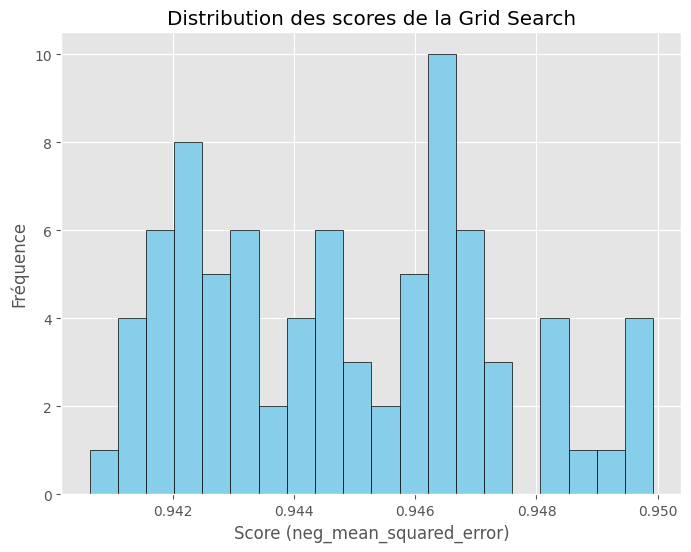

In [192]:
results = grid_search.cv_results_

# Extraire les scores de chaque combinaison d'hyperparamètres
scores = results['mean_test_score']

# Tracer l'histogramme des scores
plt.figure(figsize=(8, 6))
plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des scores de la Grid Search")
plt.xlabel("Score (neg_mean_squared_error)")
plt.ylabel("Fréquence")
plt.show()

#### LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

# Définition du modèle de régression linéaire
lr = LinearRegression()

# Entraînement du modèle
lr.fit(X_train_simple, y_train_simple)

# Prédictions et évaluation
y_pred_lr = lr.predict(X_dev_simple)
mse_lr = mean_squared_error(y_dev_simple, y_pred_lr)

print(f"Linear Regression - MSE: {mse_lr:.2f}")


SVR

In [ ]:
from sklearn.svm import SVR

# Définition du modèle SVR
svr = SVR()

# Grille d'hyperparamètres
param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [1, 10]
}

# Grid Search
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search_svr.fit(X_train_simple, y_train_simple)

# Meilleur modèle et évaluation
best_svr = grid_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_dev_simple)
mse_svr = mean_squared_error(y_dev_simple, y_pred_svr)

print(f"SVR - Meilleurs paramètres: {grid_search_svr.best_params_}")
print(f"SVR - MSE: {mse_svr:.2f}")


#### Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Définition du modèle Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)

# Grille d'hyperparamètres
param_grid_gbr = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}

# Grid Search
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search_gbr.fit(X_train_simple, y_train_simple)

# Meilleur modèle et évaluation
best_gbr = grid_search_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_dev_simple)
mse_gbr = mean_squared_error(y_dev_simple, y_pred_gbr)

print(f"Gradient Boosting - Meilleurs paramètres: {grid_search_gbr.best_params_}")
print(f"Gradient Boosting - MSE: {mse_gbr:.2f}")



Metrics that are going to be used in order to measure resulting models:

* Mean Squared  Error (MSE)

    $$\textrm{MSE} = \frac{1}{n} \times \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

* Mean Absolute Error (MAE)

    $$\textrm{MAE} = \frac{1}{n} \times \sum_{i=1}^{n} |y_i - \hat{y}_i)|$$

* Mean Relative Error (MRE)

    $$\textrm{MRE} = 100 \times \frac{1}{n} \times \sum_{i=1}^{n} |\frac{y_i - \hat{y}_i}{y_i}|$$
    
    $$\hat{y}_i - \textrm{predicted value}$$
    $$y_i - \textrm{given / real value}$$

#### Random Forest Classification

More information about random forest in scikit learn can be found [1.11.2. Forests of randomized trees](http://scikit-learn.org/stable/modules/ensemble.html#forest)


In [ ]:
def rf_regressor(target_output):
    """ Using Random Forest with Regressors.  
    
        Detailed information here:
            - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    """
    
    if target_output not in ("Y1", "Y2"):
        print ('No such output variable column existing.')
        return None
        
    import sklearn
    import pandas as pd
    from sklearn import model_selection
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # data
    X =  df[target_cols_X].values
    Y =  df[mapping[target_output]].values

    # splitting in train and test 
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, random_state = 1)
    
    # parameters
    seed         = 7
    max_features = 8
    num_trees    = 50
    
    rf = RandomForestRegressor(n_estimators=num_trees, max_features=max_features, verbose=0)
    # 
    rf_model = rf.fit(X_train, Y_train)
    
    print ('MSE (unseen): {0}'.format(mean_squared_error(rf_model.predict(X_test), Y_test)))
    print ('MAE (unseen): {0}'.format(mean_absolute_error(rf_model.predict(X_test), Y_test)))
    
    coef_part = (100 * (1/Y_test.size))
    sum_part = sum((abs(rf_model.predict(X_test) - Y_test)) / Y_test)
    print ('MRE (unseen): {0}'.format(coef_part * sum_part))
    
    
#     kfold = model_selection.KFold(n_splits=num_splits, random_state=seed)
#     results = model_selection.cross_val_score(model, X, Y, cv=kfold)

    num_splits   = 10
    results = model_selection.cross_val_score(rf, X, Y, cv=num_splits)
    
    print (results)
    print('\nRF Mean Results: {0}\n\n'.format(results.mean()))   
    print('Accuracy: %0.2f (+/- %0.2f)' % (results.mean(), results.std() * 2))
    
    #model.fit(X, Y)
    #print (model.decision_path(X))
    #print (rf.get_params())

rf_regressor(target_output='Y1')
# rf_regressor(target_output="Y1")
# rf_regressor(target_output="Y2")

MSE (unseen): 0.2716297743749998
MAE (unseen): 0.3803718750000005
MRE (unseen): 1.6370934342537455
[ 0.721  0.998  0.997  0.996  0.997  0.997  0.998  0.997  0.995  0.996]

RF Mean Results: 0.9691778935013973


Accuracy: 0.97 (+/- 0.17)
